## 1. Dependencies

Packages are installed from a dataset because competition rules restrict internet usage. Packages are in [this](https://www.kaggle.com/gunesevitan/osic-pulmonary-fibrosis-datasets) dataset.

* `gdcm==2.8.9`
* `nrrd==0.4.2`

Two scans in training set requires `gdcm` to read .dcm files, but private test set scans can be read without it. `nrrd` is used for reading .nrrd files (masks).

In [1]:
# gdcm-2.8.9
!cp ../input/osic-pulmonary-fibrosis-datasets/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2

!pip install ../input/osic-pulmonary-fibrosis-datasets/pynrrd-master -f ./ --no-index # nrrd-0.4.2

gdcm/
gdcm/conda-4.8.4-py37hc8dfbb8_2.tar.bz2
gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
gdcm/libjpeg-turbo-2.0.3-h516909a_1.tar.bz2

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
Looking in links: ./
Processing /kaggle/input/osic-pulmonary-fibrosis-datasets/pynrrd-master
  Created wheel for pynrrd: filename=pynrrd-0.4.2-py2.py3-none-any.whl size=18547 sha256=acd768ecb699621a8f67962ae7e977c648194070931b88abe703c31b022f45aa
  Stored in directory: /root/.cache/pip/wheels/e5/9b/59/b02937e072d9839bfe8c5e4762232f0bebd10f27ec23bedaff
Successfully built pynrrd


* `efficientnet_pytorch==0.6.3`
* `pretrainedmodels==0.7.4`
* `timm==0.1.20`

`timm-0.1.20` has to be installed initially because `segmentation_models_pytorch` requires that specific version. It is upgraded after installing `segmentation_models_pytorch`.

In [2]:
!pip install ../input/osic-pulmonary-fibrosis-datasets/efficientnet_pytorch-0.6.3 -f ./ --no-index # efficientnet_pytorch-0.6.3
!pip install ../input/osic-pulmonary-fibrosis-datasets/pretrained-models.pytorch -f ./ --no-index # pretrainedmodels-0.7.4
!pip install ../input/osic-pulmonary-fibrosis-datasets/timm-0.1.20-py3-none-any.whl # timm-0.1.20

Looking in links: ./
Processing /kaggle/input/osic-pulmonary-fibrosis-datasets/efficientnet_pytorch-0.6.3
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=a1d54556441840c2e7bbe85fff1266284a7a1a6b497dee03b96f9d223a6c742e
  Stored in directory: /root/.cache/pip/wheels/1b/ed/af/d2df4d9d57e031715dff33ec36f66ac15a2f39bf282581a970
Successfully built efficientnet-pytorch
Looking in links: ./
Processing /kaggle/input/osic-pulmonary-fibrosis-datasets/pretrained-models.pytorch
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=62520 sha256=a108860a2ad6d5060af00a18677fb80df46599047e96a25c105182b73866bf2b
  Stored in directory: /root/.cache/pip/wheels/28/87/eb/9ce40b2011a07d86ab7564ad72bcbbab5f1000c6a90e608c8f
Successfully built pretrainedmodels
Processing /kaggle/input/osic-pulmonary-fibrosis-datasets/timm-0.1.20-py3-none-any.whl


* `segmentation_models_pytorch==0.1.2`
* `timm==0.2.1`

A single line is changed in `segmentation_models_pytorch.encoders.timm_efficientnet.py` module because it was throwing an import error. Line 4 is changed from:

`from timm.models.efficientnet import EfficientNet, Swish` 

to

`
from timm.models.layers.activations import Swish
from timm.models.efficientnet import EfficientNet
`

After `segmentation_models_pytorch` is installed successfully, `timm` version is upgraded from `0.1.20` to `0.2.1`. Upgrading `timm` displays this error; `ERROR: segmentation-models-pytorch 0.1.2 has requirement timm==0.1.20, but you'll have timm 0.2.1 which is incompatible.`, but it is installed without any problem.

In [3]:
!pip install ../input/osic-pulmonary-fibrosis-datasets/segmentation_models_pytorch-0.1.2 -f ./ --no-index # segmentation_models_pytorch-0.1.2
!pip install ../input/osic-pulmonary-fibrosis-datasets/timm-0.2.1-py3-none-any.whl # timm-0.2.1

Looking in links: ./
Processing /kaggle/input/osic-pulmonary-fibrosis-datasets/segmentation_models_pytorch-0.1.2
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.2-py3-none-any.whl size=53937 sha256=8818c22305b8f0d310ca19d190f0442fdbe90a7e26faeef452effa950edd0f92
  Stored in directory: /root/.cache/pip/wheels/93/c0/20/e7057d7c7e421d8c17c9a738077360b9c8736c2ba25ad791ba
Successfully built segmentation-models-pytorch
Processing /kaggle/input/osic-pulmonary-fibrosis-datasets/timm-0.2.1-py3-none-any.whl
ERROR: segmentation-models-pytorch 0.1.2 has requirement timm==0.1.20, but you'll have timm 0.2.1 which is incompatible.
  Attempting uninstall: timm
    Found existing installation: timm 0.1.20
    Uninstalling timm-0.1.20:
      Successfully uninstalled timm-0.1.20


In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import random
import gc
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy.stats import skew, mode, kurtosis
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import gdcm
import pydicom
import nrrd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, BatchNormalization, GaussianDropout, Activation
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

SEED = 1337

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)    
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)

In [5]:
df_train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
df_submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

print(f'Training Set Shape = {df_train.shape} - Patients = {df_train["Patient"].nunique()}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape = {df_test.shape} - Patients = {df_test["Patient"].nunique()}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Sample Submission Shape = {df_submission.shape}')
print(f'Sample Submission Memory Usage = {df_submission.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape = (1549, 7) - Patients = 176
Training Set Memory Usage = 0.08 MB
Test Set Shape = (5, 7) - Patients = 5
Test Set Memory Usage = 0.00 MB
Sample Submission Shape = (730, 3)
Sample Submission Memory Usage = 0.02 MB


## 2. Preprocessing

### 2.1. Tabular Data

Duplicate measurements on the same `[Patient, Weeks]` groups are averaged and duplicate rows are dropped.

Categorical features; `Sex` and `SmokingStatus` are label encoded and one hot encoded.

`Weeks_Passed` feature is created for capturing the effects of time on `FVC`, and `Age` feature is incremented by `1 / 52` for every passed week.

First measurement of every patient is provided in test set and that feature is named `FVC_Baseline`. First `Percent` value of every patient is used as a feature, not the continous values. Scale can be set to `True` for scaling continuous features but scaled features yield worse results.

### 2.2. Cross-validation

Implemented three different cv schemes because each of them aren't always correlated with the public leaderboard score. Voting is done between those cv schemes based on the score change. Those custom cv schemes are:

* Double Stratified Shuffled KFold on `Patient` groups. Patients are stratified by `Sex` and `SmokingStatus` features and groups are shuffled.
* Cluster Stratified Shuffled KFold on `Patient` groups. Patients are clustered by their last two `FVC` values and those clusters are used for stratification.
* Regular Shuffled KFold on `Patient` groups. Patients are shuffled without any stratification.

All of the cv schemes above are splitting data on `Patient` level so there is no leak between folds. Data is split into 2 folds because of the low patient count (176).

In [6]:
class TabularDataPreprocessor:
    
    def __init__(self, train, test, submission, n_folds, shuffle, ohe, scale):
        
        self.train = train.copy(deep=True)
        self.train.sort_values(by=['Patient', 'Weeks'], inplace=True)        
        self.test = test.copy(deep=True)
        self.submission = submission.copy(deep=True)
                
        self.n_folds = n_folds
        self.shuffle = shuffle
        
        self.ohe = ohe
        self.scale = scale
        
    def drop_duplicates(self):
        
        """        
        Calculate mean FVC and mean Percent of [Patient, Weeks] groups and drop duplicate rows
        This operation takes the mean of multiple measurements in a single week and uses it
        """
        
        self.train['FVC'] = self.train.groupby(['Patient', 'Weeks'])['FVC'].transform('mean')
        self.train['Percent'] = self.train.groupby(['Patient', 'Weeks'])['Percent'].transform('mean')
        self.train.drop_duplicates(inplace=True)
        self.train.reset_index(drop=True, inplace=True)
        
    def label_encode(self):
        
        """
        Label Encode categorical features
        """
                    
        for df in [self.train, self.test]:
            df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})
            df['Sex'] = df['Sex'].astype(np.uint8)
            df['SmokingStatus'] = df['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 1, 'Currently smokes': 2})
            df['SmokingStatus'] = df['SmokingStatus'].astype(np.uint8)
            
    def one_hot_encode(self):
        
        """
        One-hot Encode categorical features
        """
        
        for df in [self.train, self.test]:
            df['Male'] = 0
            df['Female'] = 0
            df.loc[df['Sex'] == 0, 'Male'] = 1
            df.loc[df['Sex'] == 1, 'Female'] = 1
            
            df['Never smoked'] = 0
            df['Ex-smoker'] = 0
            df['Currently smokes'] = 0
            df.loc[df['SmokingStatus'] == 0, 'Never smoked'] = 1
            df.loc[df['SmokingStatus'] == 1, 'Ex-smoker'] = 1
            df.loc[df['SmokingStatus'] == 2, 'Currently smokes'] = 1
            
            for encoded_col in ['Male', 'Female', 'Never smoked', 'Ex-smoker', 'Currently smokes']:
                df[encoded_col] = df[encoded_col].astype(np.uint8)

    def create_folds(self):
        
        """
        Creates n number of folds for three different cross-validation schemes (n should be selected as 2 because of the low patient count)
            
        1. Double Stratified Shuffled Folds
        -----------------------------------
        Patients are stratified by Sex and SmokingStatus features and groups are shuffled
        Patients listed below are split into n folds with all of their FVC measurements
        
        Male_Ex-smoker             106 / n
        Male_Never smoked           26 / n
        Female_Never smoked         23 / n
        Female_Ex-smoker            12 / n
        Male_Currently smokes        7 / n
        Female_Currently smokes      2 / n
        
        2. Cluster Stratified Shuffled Folds
        ------------------------------------
        Patients are clustered by their last two FVC values and clusters are stratified
        Patients listed below are split into n folds with all of their FVC measurements
        
        Cluster 2    167 / n
        Cluster 3      7 / n
        Cluster 1      2 / n  
        
        3. Regular Shuffled Folds
        -------------------------
        Patient groups are shuffled into n folds        
        Patient Count 176 / n
        """
        
        # Double Stratified Shuffled Folds
        self.train['Sex_SmokingStatus'] = self.train['Sex'].astype(str) + '_' + self.train['SmokingStatus'].astype(str)
        for group in self.train['Sex_SmokingStatus'].unique():
            patients = self.train[self.train['Sex_SmokingStatus'] == group]['Patient'].unique()
            
            if self.shuffle:
                np.random.seed(SEED)
                np.random.shuffle(patients)
                
            for fold, patient_group in enumerate(np.array_split(patients, self.n_folds), 1):
                self.train.loc[self.train['Patient'].isin(patient_group), 'CV1_Fold'] = fold
               
        # Cluster Stratified Shuffled Folds
        for patient_name in self.train['Patient'].unique():
            z = (self.train[(self.train['Patient'] == patient_name)]['FVC'].values[-2:] - self.train[(self.train['Patient'] == patient_name)]['FVC'].values[-2:].mean()) / self.train[(self.train['Patient'] == patient_name)]['FVC'].values[-2:].std()
            reg = LinearRegression(normalize=True).fit(self.train[(self.train['Patient'] == patient_name)]['Weeks'].values[-2:].reshape(-1, 1), z)

            self.train.loc[self.train['Patient'] == patient_name, 'Intercept'] = reg.intercept_
            self.train.loc[self.train['Patient'] == patient_name, 'Coef'] = reg.coef_[0]
            
        self.train.loc[self.train['Coef'] > 0.4, 'Cluster'] = 1
        self.train.loc[(self.train['Coef'] < 0.4) & (self.train['Coef'] > -0.4), 'Cluster'] = 2
        self.train.loc[self.train['Coef'] < -0.4, 'Cluster'] = 3

        for group in self.train['Cluster'].unique():
            patients = self.train[self.train['Cluster'] == group]['Patient'].unique()

            if self.shuffle:
                np.random.seed(SEED)
                np.random.shuffle(patients)

            for fold, patient_group in enumerate(np.array_split(patients, self.n_folds), 1):
                self.train.loc[self.train['Patient'].isin(patient_group), 'CV2_Fold'] = fold
               
        # Regular Shuffled Folds
        patients = self.train['Patient'].unique()
        np.random.seed(SEED)
        np.random.shuffle(patients)
        
        for fold, patient_group in enumerate(np.array_split(patients, self.n_folds), 1):
            self.train.loc[self.train['Patient'].isin(patient_group), 'CV3_Fold'] = fold
            
        self.train.drop(columns=['Sex_SmokingStatus', 'Intercept', 'Coef', 'Cluster'], inplace=True)        
    
    def create_tabular_features(self):
        
        self.drop_duplicates()
        self.create_folds()
        self.label_encode()
        if self.ohe:
            self.one_hot_encode()
            
        # Training set preparation
        self.train['Type'] = 'Train'
        self.train['Weeks_Passed'] = self.train['Weeks'] - self.train.groupby('Patient')['Weeks'].transform('min')
        self.train['FVC_Baseline'] = self.train.groupby('Patient')['FVC'].transform('first')
        
        # Use Baseline Percent or Percent for training set?
        # Percent obviously increases CV score since it correlates well with FVC
        # However, only first Percent value is given for test set
        # In that case, using Percent by itself is wrong and doesn't make sense
        # Even though it is wrong, it increases public leaderboard score as well
        # Can we trust public leaderboard improvement and use Percent?
        self.train['Percent'] = self.train.groupby('Patient')['Percent'].transform('first')
        # Comment this line out for using Percent feature
            
        # Test set preparation
        self.submission['Type'] = 'Test'
        self.submission['Patient'] = self.submission['Patient_Week'].apply(lambda x: x.split('_')[0]).astype(str)
        self.submission['Weeks'] = self.submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
        self.submission.drop(columns=['Patient_Week', 'FVC', 'Confidence'], inplace=True)
        self.test = self.submission.merge(self.test.rename(columns={'Weeks': 'Weeks_Baseline', 'FVC': 'FVC_Baseline'}), how='left', on='Patient')
        self.test['Weeks_Passed'] = self.test['Weeks'] - self.test['Weeks_Baseline']
        self.test.drop(columns=['Weeks_Baseline'], inplace=True)
        
        df_all = pd.concat([self.train, self.test], ignore_index=True, axis=0)        
        df_all['Age'] += (df_all['Weeks_Passed'] / 52)
        df_all['Age'] = df_all['Age'].astype(np.float32)
        df_all['FVC_Baseline'] = df_all['FVC_Baseline'].astype(np.float32)
        df_all['Percent'] = df_all['Percent'].astype(np.float32)
        df_all['Weeks_Passed'] = df_all['Weeks_Passed'].astype(np.float32)        
        df_all['Weeks'] = df_all['Weeks'].astype(np.int16)

        df_all['FVC'] = df_all['FVC'].astype(np.float32)
        
        if self.scale:
            scale_features = ['FVC_Baseline', 'Age', 'Percent', 'Weeks_Passed']
            scaler = MinMaxScaler()
            df_all.loc[:, scale_features] = scaler.fit_transform(df_all.loc[:, scale_features])
        
        df_train = df_all.loc[df_all['Type'] == 'Train', :].drop(columns=['Type'])
        for i in range(1, 4):
            df_train[f'CV{i}_Fold'] = df_train[f'CV{i}_Fold'].astype(np.uint8)
        df_test = df_all.loc[df_all['Type'] == 'Test', :].drop(columns=['Type', 'FVC', 'CV1_Fold', 'CV2_Fold', 'CV3_Fold'])    
        
        return df_train.copy(deep=True), df_test.reset_index(drop=True).copy(deep=True)


In [7]:
tabular_data_preprocessor = TabularDataPreprocessor(train=df_train,
                                                    test=df_test, 
                                                    submission=df_submission, 
                                                    n_folds=2,
                                                    shuffle=True,
                                                    ohe=True,
                                                    scale=False)

df_train, df_test = tabular_data_preprocessor.create_tabular_features()

print(f'Training Set (Tabular Features) Shape = {df_train.shape} - Patients = {df_train["Patient"].nunique()}')
print(f'Training Set (Tabular Features) Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set (Tabular Features) Shape = {df_test.shape} - Patients = {df_test["Patient"].nunique()}')
print(f'Test Set (Tabular Features) Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set (Tabular Features) Shape = (1542, 17) - Patients = 176
Training Set (Tabular Features) Memory Usage = 0.07 MB
Test Set (Tabular Features) Shape = (730, 13) - Patients = 5
Test Set (Tabular Features) Memory Usage = 0.02 MB


### 2.3. Segmentation Models

In [8]:
class CoordinateConvolution3D(nn.Module):
    
    def __init__(self, in_channels, with_radius=False, **kwargs):
        
        super(CoordinateConvolution3D, self).__init__()
        self.params = nn.Parameter(torch.ones((2)))
        self.conv = nn.Conv2d(in_channels + 1, **kwargs)

    def forward(self, X, Z):
        
        batch_size, channels, dim_x, dim_y = X.size()
        zz_channel = torch.ones([1, 1, dim_x, dim_y])
        
        out = torch.cat([X, zz_channel.to(X.device) * Z.reshape(-1, 1, 1, 1) * self.params[0] ** 2 + self.params[1]], dim=1)
        return self.conv(out)
    

class SegmenterModel(nn.Module):
    
    def __init__(self, checkpoint=None):
        
        super().__init__()
        self.model = smp.Unet('timm-efficientnet-b0', classes=3, encoder_weights=None, decoder_attention_type='scse')
        
        self.final = CoordinateConvolution3D(
            self.model.segmentation_head[0].in_channels,
            out_channels = self.model.segmentation_head[0].out_channels,
            kernel_size = self.model.segmentation_head[0].kernel_size,
            stride = self.model.segmentation_head[0].stride,
            padding = self.model.segmentation_head[0].padding,
            bias = True
        )
        self.model.segmentation_head = nn.Identity()
        
        if checkpoint is not None:
            checkpoint = torch.load(checkpoint)['model_state_dict']
            for k in list(checkpoint.keys()):
                checkpoint[k[len('module.'):]] = checkpoint[k]
                del checkpoint[k]
            self.load_state_dict(checkpoint)
        
    def forward(self, x, z):
        return self.final(self.model(x), z)


class PatientDataset(Dataset):

    def __init__(self, scans, data_info_path):
        
        super().__init__()
        self.scans = scans
        self.data_info = np.load(data_info_path)
        self.n_slices = len(self)
        
    def __getitem__(self, index):
        
        if index == 0:
            scan = np.concatenate([self.scans[index:index + 2], np.expand_dims(self.scans[index + 1], axis=0)], axis=0)
        elif index == self.n_slices - 1:
            scan = np.concatenate([np.expand_dims(self.scans[index - 1], axis=0), self.scans[index - 1:index + 1]], axis=0)
        else:
            scan = np.array(self.scans[index - 1:index + 2])

        scan = torch.FloatTensor((scan - self.data_info[0]) / self.data_info[1])
        z_pos = torch.FloatTensor([float(index) / self.n_slices]) - 0.5
        
        return scan, z_pos

    def __len__(self):
        return len(self.scans)
    
    
class InferenceEngine:
    
    def __init__(self, batch_size, num_workers):
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
            
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def load_models(self):
                
        # Distilled Noisy Lung Trachea Segmentation Model
        data_info_201_path = '../input/osic-pulmonary-fibrosis-datasets/Segmentation Models/201_data_info.npy'
        model_201_noisy_lung_trachea_path = '../input/osic-pulmonary-fibrosis-datasets/Segmentation Models/201_noisy_lung_trachea_model.bin'
        model_201_noisy_lung_trachea = SegmenterModel(model_201_noisy_lung_trachea_path).to(self.device)
        model_201_noisy_lung_trachea.eval()

        # Distilled Smooth Lung Heart Segmentation Model
        data_info_202_path = '../input/osic-pulmonary-fibrosis-datasets/Segmentation Models/202_data_info.npy'
        model_202_smooth_lung_heart_path = '../input/osic-pulmonary-fibrosis-datasets/Segmentation Models/202_smooth_lung_heart_model.bin'
        model_202_smooth_lung_heart = SegmenterModel(model_202_smooth_lung_heart_path).to(self.device)
        model_202_smooth_lung_heart.eval()

        return model_201_noisy_lung_trachea, data_info_201_path, model_202_smooth_lung_heart, data_info_202_path
        
    def run_inference(self, scan, model, data_info_path, softmax):
        
        loader = DataLoader(PatientDataset(scan, data_info_path), 
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            shuffle=False,
                            pin_memory=True)
        
        model.eval()      
        predictions = []
        
        for input_scans, input_zpos in loader:
            with torch.no_grad():
                input_scans, input_zpos = input_scans.to(self.device), input_zpos.to(self.device)
                outputs = model(input_scans, input_zpos)
                
                if softmax:
                    outputs = F.softmax(outputs, dim=1, _stacklevel=5)
                else:
                    outputs = F.sigmoid(outputs)
                    
                predictions.append(outputs.detach().cpu())
                
        if len(scan) > self.batch_size:
            predictions = torch.cat(predictions, dim=0)
        else:
            predictions = predictions[0]
                
        torch.cuda.empty_cache()
        return predictions.numpy()


### 2.4. Image Data

In [9]:
class ImageDataPreprocessor:
    
    def __init__(self, train, test, resize_shape, window_min, window_max, y_min, y_max):
        
        self.train = train.copy(deep=True)
        self.test = test.copy(deep=True)
        
        self.resize_shape = resize_shape
        
        self.window_min = window_min
        self.window_max = window_max
        self.y_min = y_min
        self.y_max = y_max
    
    def resize(self, s, interpolate=False):
        
        """
        Resize slices to given size with nearest neighbor interpolation or linear interpolation

        Parameters
        ----------
        s : numpy array, shape = (Rows, Columns)
        2D numpy array of slice
        
        interpolate: boolean
        If True, use linear interpolation
        If False, use nearest neighbor interpolation

        Returns
        -------
        s : numpy array, shape = (resize_shape[0], resize_shape[1])
        2D numpy array after resized to resize_shape
        """
        
        if s.shape[0] != self.resize_shape[0] and s.shape[1] != self.resize_shape[1]:
            return cv2.resize(s, self.resize_shape, interpolation=cv2.INTER_LINEAR if interpolate else cv2.INTER_NEAREST)

        return s
    
    def remove_padding(self, v, masks=None):
        
        """
        Remove junk padding from scan if present

        Parameters
        ----------
        v : numpy array, shape = (Depth, Rows, Columns)
        3D numpy array of volumes with padding
        
        masks: dictionary of numpy arrays, shape = (Depth, Rows, Columns)
        3D numpy arrays of masks with padding

        Returns
        -------
        v : numpy array, shape = (Depth, (Rows - All Constant Rows), (Columns - All Constant Columns))
        3D numpy array after all constant rows and columns are dropped
        
        masks : dictionary of numpy arrays, shape = (Depth, (Rows - All Constant Rows), (Columns - All Constant Columns))
        3D numpy arrays of masks after all constant rows and columns are dropped
        """

        if v.shape[1] == self.resize_shape[0] and v.shape[2] == self.resize_shape[1]:
            return v, masks

        # Constant value is taken from the first voxel
        constant_value = v[0, 0, 0]

        # Remove all constant horizontal lines
        mid_slice = v[v.shape[0] // 2]
        indexer = mid_slice == constant_value
        v = v[:, ~np.all(indexer, axis=1)]
        for key in list(masks.keys()):
            if masks[key] is None:
                continue
            masks[key] = masks[key][:, ~np.all(indexer, axis=1)]            
        del mid_slice, indexer

        # Remove all constant vertical lines 
        mid_slice = v[v.shape[0] // 2]
        indexer = mid_slice == constant_value
        v = v[:, :, ~np.all(indexer, axis=0)]
        for key in list(masks.keys()):
            if masks[key] is None:
                continue
            masks[key] = masks[key][:, :, ~np.all(indexer, axis=0)]
        del mid_slice, indexer

        return v, masks
    
    def padded_crop(self, v, btop, bbottom, bleft, bright, bg):
        
        v_padded = np.ones((v.shape[0], bbottom - btop, bright - bleft), dtype=v.dtype) * bg
        
        pad_top = 0 if btop > 0 else -btop
        pad_bottom = 0 if bbottom < v.shape[1] else bbottom - v.shape[1]
        pad_left = 0 if bleft > 0 else -bleft
        pad_right = 0 if bright < v.shape[2] else bright - v.shape[2]
        
        v_padded[:, pad_top:v_padded.shape[1] - pad_bottom, pad_left:v_padded.shape[2] - pad_right,] = v[:, max(0, btop):min(v.shape[1], bbottom), max(0, bleft):min(v.shape[2], bright)]
        return v_padded
        
    def find_spikes(self, v):
        
        """
        Find the spikes in volumes

        Parameters
        ----------
        v : numpy array, shape = (Depth, Rows, Columns)
        3D numpy array of volume

        Returns
        -------
        tuple of spikes in v
        """
        
        mean = v.mean()
        std = v.std() * 4.5
        try:
            # Take values 4.5 sigma away from mean
            # It is inside a try/except block because a scan in private test set throws error here
            hist = np.histogram(v[(v < mean + std) & (v > mean - std)].flatten(), bins=50, density=True)
            peaks, peak_properties = find_peaks(hist[0], distance=3, prominence=0.00015, rel_height=0.5)

            return (hist[1][peaks[-1] - 1], hist[1][peaks[-1]], hist[1][peaks[-1] + 1], hist[1][peaks[-1] + 2])
        except:
            return (None, None, None, None)

    def fix_hu(self, v, slope, intercept):
        
        """
        Fix HU values in 3D volume

        Parameters
        ----------
        v : numpy array, shape = (Depth, Rows, Columns)
        3D numpy array of volume
        
        slope: int
        Rescale Slope from DICOM metadata
        
        intercept: int
        Rescale Intercept from DICOM metadata

        Returns
        -------
        v : numpy array, shape = (Depth, Rows, Columns)
        3D numpy array of volume with shifted hu values
        """
                
        v = (v * slope + intercept).clip(-32768, 32767).astype(np.int16)        
        a, _, _, d = self.find_spikes(v=v)
        if a and d:
            mid = (a + d) / 2
            if abs(mid) > 512:
                v -= np.int16(round(mid / 1024) * 1024)
        return v
    
    def window(self, v, window_min, window_max, y_min, y_max):
        
        """
        Window HU values in 3D volume

        Parameters
        ----------
        v : numpy array, shape = (Depth, Rows, Columns)
        3D numpy array of volume
        
        window_min: int       
        window_max: int
        y_min: int
        y_max: int

        Returns
        -------
        v : numpy array, shape = (Depth, Rows, Columns)
        3D numpy array of volume with windowed hu values
        """
            
        v = ((v - window_min) / (window_max - window_min) * (y_max - y_min) + y_min).clip(0, 255).astype(np.uint8)
        return v
        
    def load_scan(self, scan_path, masks=None):
        
        """
        Preprocess and load the given patients scan

        Parameters
        ----------
        scan_path : str Path of the CT scan

        Returns
        -------
        scan : numpy array, shape = (n_slices, self.resize_shape[0], self.resize_shape[1])
        numpy array after the cropped and resized slices are stacked
        metadata : dict
        dictionary of processed metadata        
        """

        # Load scan from the given scan path
        files_path = glob(f'{scan_path}/*.dcm')
        patient_directory = [pydicom.dcmread(f) for f in files_path]
        
        if masks is not None:
            pass
        else:
            masks = {
                'noisy_lung': None,
                'smooth_lung': None,
                'heart': None,
                'trachea': None
            }
        
        try:
            # Sort slices by ImagePositionPatient Z if the field exists
            patient_directory.sort(key=lambda s: float(s.ImagePositionPatient[2]))
            slice_positions = np.round([s.ImagePositionPatient[2] for s in patient_directory], 4)
            non_duplicate_idx = np.unique([np.where(slice_position == slice_positions)[0][0] for slice_position in slice_positions])
            del slice_positions
        except AttributeError:
            # If ImagePositionPatient doesn't exist, sort them by InstanceNumber
            # (Every CT scan has ImagePositionPatient in private test set)
            patient_directory.sort(key=lambda s: int(s.InstanceNumber))
            instance_numbers = np.array([int(s.InstanceNumber) for s in patient_directory])
            non_duplicate_idx = np.unique([np.where(instance_number == instance_numbers)[0][0] for instance_number in instance_numbers])
            del instance_numbers

        keys = list(masks.keys())
        for key in keys:
            if not masks[key]:
                # Explicitly set empty array to None
                masks[key] = None
                continue
                
            mask, _ = nrrd.read(masks[key][0])
            mask = mask.transpose(2, 1, 0).astype(np.uint8)
            
            assert mask.shape[0] == len(patient_directory)
            assert (mask.min() == 0) and (mask.max() == 1)
            
            masks[key] = (mask > 0).astype(np.uint8)
            
        # Order of operations
        if masks['noisy_lung'] is not None and masks['smooth_lung'] is not None:
            # All noisy lung must be contained in non-noisy lung
            try:
                masks['smooth_lung'][masks['noisy_lung'] > 0] = 1
            except:
                print(f"{scan_path} smooth_lung mask != heart mask, {masks['smooth_lung'].shape}, {masks['heart'].shape}")
                return
            
        if masks['noisy_lung'] is not None and masks['trachea'] is not None:
            # Noisy lung must have trachea removed
            try:
                masks['noisy_lung'][masks['trachea'] > 0] = 0
            except:
                print(f"{scan_path} trachea mask != noisy lung mask, {masks['trachea'].shape}, {masks['noisy_lung'].shape}")
                return
            
        if masks['heart'] is not None and masks['smooth_lung'] is not None:
            # Heart must have smooth lung removed
            try:
                masks['heart'][masks['smooth_lung'] > 0] = 0
            except:
                print(f"{scan_path} smooth_lung mask != heart mask, {masks['smooth_lung'].shape}, {masks['heart'].shape}")
                return
            
        # Slice indices with the same ImagePositionPatient Z or InstanceNumber are removed from scan and masks
        patient_directory = np.array(patient_directory)[non_duplicate_idx]
        for key in keys:
            if masks[key] is None:
                continue
            masks[key] = masks[key][non_duplicate_idx]
        del non_duplicate_idx

        # Slice indices of empty slices are removed from scan and masks
        non_empty_idx = [i for i, s in enumerate(patient_directory) if not np.all(s.pixel_array == s.pixel_array[0, 0], axis=(-1, -2))]
        patient_directory = patient_directory[non_empty_idx]
        for key in keys:
            if masks[key] is None:
                continue
            masks[key] = masks[key][non_empty_idx]
        del non_empty_idx
            
        # DICOM Metadata
        metadata = {}
        
        metadata['RescaleSlope'] = patient_directory[0].RescaleSlope
        metadata['RescaleIntercept'] = patient_directory[0].RescaleIntercept
        
        pixel_spacings = np.zeros((len(patient_directory), 2))
        slice_positions = np.zeros((len(patient_directory)))
        slice_thickness = np.zeros((len(patient_directory)))
        
        for i, s in enumerate(patient_directory): 
            try:
                pixel_spacings[i] = np.array(s.PixelSpacing)
            except AttributeError:
                pixel_spacings[i] = np.nan
                
            try:
                slice_positions[i] = s.ImagePositionPatient[2]
            except AttributeError:
                slice_positions[i] = np.nan
                
            try:
                slice_thickness[i] = float(s.SliceThickness)
            except AttributeError:
                slice_thickness[i] = np.nan
        
        # Fill missing pixel spacings and slice thinknesses with nanmean
        pixel_spacings[np.isnan(pixel_spacings[:, 0]), 0] = np.nanmean(pixel_spacings[:, 0])
        pixel_spacings[np.isnan(pixel_spacings[:, 1]), 1] = np.nanmean(pixel_spacings[:, 1])
        slice_thickness[np.isnan(slice_thickness)] = np.nanmean(slice_thickness)
        
        # All PixelSpacing values are same in a CT scan but they have to be rounded and averaged along the axis 0 for floating point precision errors
        metadata['PixelSpacing'] = list(np.round(pixel_spacings.mean(axis=0), 3))
        del pixel_spacings
        
        # Two of the patients don't have their SpacingBetweenSlices or ImagePositionPatient fields so it is impossible to retrieve their SliceSpacings
        # Their SliceSpacings are filled with the most common values of similar CT scans
        # Most common rounded SliceSpacing value is selected for rest of the patients
        patient_name = scan_path.split('/')[-1]
        if patient_name == 'ID00128637202219474716089':
            metadata['SliceSpacing'] = np.array([5.0] * len(patient_directory))
        elif patient_name == 'ID00132637202222178761324':
            metadata['SliceSpacing'] = np.array([0.7] * len(patient_directory))
        else:
            metadata['SliceSpacing'] = np.abs(np.diff(np.round(slice_positions, 3)))
            metadata['SliceSpacing'] = np.concatenate([metadata['SliceSpacing'], [metadata['SliceSpacing'][-1]]])
            
            nan_mask = np.isnan(metadata['SliceSpacing'])
            if metadata['SliceSpacing'].shape[0] == nan_mask.sum():
                # All SliceSpacing values are NaNs
                # Set SliceSpacing by filling values based on slice count
                # This power function is regresses from known slice count - slice spacing pairs:
                metadata['SliceSpacing'] = np.array([275.79 * (len(patient_directory) ** (-0.987))] * len(patient_directory))
                
                # Sandor's suggestions RE the above (override!):
                # If slice count < 50,  slicespacing is 5 mm (99%)
                # If slice  count > 150, slicespacing is 1 mm (99%)
                if len(patient_directory) < 50:
                    metadata['SliceSpacing'] = np.array([5.0] * len(patient_directory))
                elif len(patient_directory) > 150:
                    metadata['SliceSpacing'] = np.array([1.0] * len(patient_directory))
                # Between 50 and 150 no good estimation can be given... i would go with 5 mm up to 75 and with 3 mm to 150
                
            elif nan_mask.sum() > 0:
                # Fill intermittant NAs with the mean value
                metadata['SliceSpacing'][nan_mask] = np.nanmean(metadata['SliceSpacing'])
            del nan_mask
        del slice_positions
                
        metadata['SliceThickness'] = slice_thickness
        del slice_thickness
        
        # Remove padding
        scan, masks = self.remove_padding(v=np.array([s.pixel_array for s in patient_directory], dtype=np.int16), masks=masks)
        del patient_directory
        
        # Ensure scans and all available all have the same dimensions
        for key in keys:
            if masks[key] is not None:
                assert masks[key].shape == scan.shape
                
        scan = self.fix_hu(v=scan, slope=metadata['RescaleSlope'], intercept=metadata['RescaleIntercept'])
        
        # Center crop 325 mm around the barycenter where values > the mean
        # Cropped 335 mm (13.2 inches) in the x-y direction 
        center = np.argwhere(scan > scan.mean()).mean(axis=0).astype(np.int16)[1:]
        bounding_box = (335 / np.array(metadata['PixelSpacing'])).astype(np.int16)
        
        metadata['original_scan_shape'] = scan.shape
        metadata['btop'] = center[0] - bounding_box[0] // 2
        metadata['bbottom'] = center[0] + bounding_box[0] // 2
        metadata['bleft'] = center[1] - bounding_box[1] // 2
        metadata['bright'] = center[1] + bounding_box[1] // 2
        metadata['mm_crop'] = 335
        del center, bounding_box
        
        scan = self.padded_crop(v=scan, btop=metadata['btop'], bbottom=metadata['bbottom'], bleft=metadata['bleft'], bright=metadata['bright'], bg=scan.min())
        for key in keys:
            if masks[key] is not None:                
                masks[key] = self.padded_crop(v=masks[key], btop=metadata['btop'], bbot=metadata['bbottom'], bleft=metadata['bleft'], bright=metadata['bright'], bg=0)
        
        # Standardize the orientation of the patient
        body = scan < -450
        if body[:int(scan.shape[0] * 0.5)].sum() > body[int(scan.shape[0] * 0.5):].sum():
            # Patient was put into the machine backwards
            scan = scan[::-1]
            for key in keys:
                if masks[key] is None: continue
                masks[key] = masks[key][::-1]
        del body

        # Bone at the 99th percentile
        threshold = np.percentile(scan.flatten(), 99)
        bone = (scan[2:-2,
                     int(scan.shape[1] * 0.17):int(scan.shape[1] * 0.83):, # Cut the table out from top/bottom
                     int(scan.shape[2] * 0.37):int(scan.shape[2] * 0.63):, # Limit the the center slices where the back bone should be
                     ] >= threshold).mean(axis=0)
        bone = bone.mean(axis=1)
        if bone[:int(bone.shape[0] * 0.5)].sum() > bone[int(bone.shape[0] * 0.5):].sum():
            # Patient is lying on their stomach
            scan = scan[:, ::-1]
            for key in keys:
                if masks[key] is None: continue
                masks[key] = masks[key][:, ::-1]                
        del threshold, bone
    
        # Rescale each one to 512x512 or whatever
        vscan = np.zeros((scan.shape[0], self.resize_shape[0], self.resize_shape[0]), dtype=np.int16)
        vmasks = {
            k: None if m is None else np.zeros((m.shape[0], self.resize_shape[0], self.resize_shape[0]), dtype=np.uint8)
            for k,m in masks.items()
        }
        
        for i, s in enumerate(scan):
            vscan[i] = self.resize(s=s, interpolate=True)
            for key in keys:
                if vmasks[key] is None: continue
                vmasks[key][i] = self.resize(s=masks[key][i], interpolate=False)

        vscan = self.window(v=vscan, window_min=self.window_min, window_max=self.window_max, y_min=self.y_min, y_max=self.y_max)
        return {'scan': vscan, **metadata, **vmasks}
    
    def find_largest_diameter(self, mask, mm_per_pixel):        
        first = np.argmax(mask, axis=2)
        last = mask.shape[2] - np.argmax(mask[:, :, ::-1], axis=2)
        last[last == mask.shape[2]] = 0
        first[first == 0] = mask.shape[2]
        return (last - first).max() * mm_per_pixel
    
    def find_volume(self, mask, mm_per_pixel, mm_slice_spacing):
        return (mask.sum(axis=(1, 2)) * mm_per_pixel * mm_per_pixel * mm_slice_spacing).sum() / 1000
    
    def find_surface_area(self, mask, mm_per_pixel, mm_slice_spacing):        
        surface_area = 0
        for idx, c in enumerate(mask):
            depth = mm_slice_spacing[idx] * np.sqrt(2)
            contours = cv2.findContours(c, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
            surface_area += sum([cv2.arcLength(cnt, closed=True) * mm_per_pixel * depth for cnt in contours])

        return surface_area
    
    def create_image_features(self):
        
        # Segmentation Models
        # ------------------------
        inference_engine = InferenceEngine(batch_size=32, num_workers=0)
        model_201_noisy_lung_trachea, data_info_201, model_202_smooth_lung_heart, data_info_202 = inference_engine.load_models()
        
        # TRAINING SET
        # ------------
        # Set this to True for creating training set features on live kernel session
        # Download features after creating them and upload them on a dataset
        # Otherwise, GPU run-time exceeds 4 hours
        if False:
            for i, patient in enumerate(self.train['Patient'].unique(), 1):
                
                # Skipping 1018 slice CT scan because Kaggle kernel RAM is not enough for inference
                # Created features are filled with mean for test purposes
                # In final submissions, they should be switched with real values
                if patient == 'ID00078637202199415319443':
                    print(f'[{i}/{len(self.train["Patient"].unique())}] Training Set - Patient: {patient} skipped\n')
                    continue
                    
                # --------------------
                # Create features here
                # --------------------
            
            features = ['smooth_lung_mean', 'smooth_lung_std', 'smooth_lung_skew',
                        'chest_diameter', 'smooth_lung_volume', 'smooth_lung_surface_area', 'smooth_lung_lower_level_calcification',
                        'noisy_lung_volume', 'noisy_lung_surface_area',
                        'heart_diameter', 'heart_volume', 'heart_surface_area',
                        'trachea_diameter', 'trachea_branching_angle']
                            
            self.train[(['Patient'] + features)].to_csv('train_features.csv', index=False)
            print('Training features are created and saved\n')
            return

        else:
            # Merging precomputed training set features from dataset
            df_train_features = pd.read_csv('../input/osic-pulmonary-fibrosis-datasets/train_features.csv').rename(columns={'patient_name': 'Patient'})
            features = ['smooth_lung_mean', 'smooth_lung_std', 'smooth_lung_skew', 'smooth_lung_kurt',
                        'chest_diameter', 'smooth_lung_volume', 'smooth_lung_surface_area', 'smooth_lung_lower_level_calcification',
                        'noisy_lung_volume', 'noisy_lung_surface_area',
                        'heart_diameter', 'heart_volume', 'heart_surface_area',
                        'trachea_diameter', 'trachea_branching_angle']
            
            self.train = self.train.merge(df_train_features[(['Patient'] + features)], how='left', on='Patient')
            print('Merged precomputed features to training set\n')
        
        # TEST SET
        # ------------
        # Computing test set features on run-time
        for i, patient in enumerate(self.test['Patient'].unique(), 1):
            
            results = self.load_scan(scan_path=f'../input/osic-pulmonary-fibrosis-progression/test/{patient}', masks=None)
            mm_per_pixel = results['mm_crop'] / results['scan'].shape[1]
            mm_slice_spacing = results['SliceSpacing']

            mask_noisy_lung_trachea = inference_engine.run_inference(results['scan'], model_201_noisy_lung_trachea, data_info_201, softmax=True)
            mask_smooth_lung_heart = inference_engine.run_inference(results['scan'], model_202_smooth_lung_heart, data_info_202, softmax=True)

            mask_smooth_lung = (mask_smooth_lung_heart[:, 1] > 0.6).astype(np.uint8)
            mask_heart = (mask_smooth_lung_heart[:, 2] > 0.6).astype(np.uint8)
            mask_noisy_lung = (mask_noisy_lung_trachea[:, 1] > 0.6).astype(np.uint8)
            mask_trachea = (mask_noisy_lung_trachea[:, 2] > 0.6).astype(np.uint8)
            del mask_smooth_lung_heart, mask_noisy_lung_trachea

            mask_smooth_lung[mask_trachea > 0] = 0 # Voxels predicted as trachea can't be smooth lung
            mask_noisy_lung[mask_smooth_lung == 0] = 0 # Voxels predicted as smooth lung are overwritten to noisy lung
            
            print(f'[{i}/{len(self.test["Patient"].unique())}] Test Set - Patient: {patient} - Scan Shape: {results["scan"].shape} ({results["scan"].nbytes >> 20}MB)')
            print(f'{" " * 6}Smooth Lung Mask Shape: {mask_smooth_lung.shape} ({mask_smooth_lung.nbytes >> 20}MB) - Heart Mask Shape: {mask_heart.shape} ({mask_heart.nbytes >> 20}MB)')
            print(f'{" " * 6}Noisy Lung  Mask Shape: {mask_noisy_lung.shape} ({mask_noisy_lung.nbytes >> 20}MB) - Trachea Mask Shape: {mask_trachea.shape} ({mask_trachea.nbytes >> 20}MB)\n')
            
            # 1. Smooth Lung Statistical Features
            # -----------------------------------
            smooth_lung = results['scan'][mask_smooth_lung > 0]
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_mean'] = smooth_lung.mean()
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_std']  = smooth_lung.std()
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_skew'] = skew(smooth_lung)
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_kurt'] = kurtosis(smooth_lung)
            del smooth_lung
                
            # 2. Smooth Lung Volume Features
            # ------------------------------
            if np.all(0 == mask_smooth_lung):
                z_min, z_max = mask_smooth_lung.shape[0] // 20, mask_smooth_lung.shape[0] // 20 * 19
                x_min, x_max = mask_smooth_lung.shape[1] // 20, mask_smooth_lung.shape[1] // 20 * 19
                y_min, y_max = mask_smooth_lung.shape[2] // 20, mask_smooth_lung.shape[2] // 20 * 19
            else:
                zs, xs, ys = np.where(mask_smooth_lung != 0)
                z_min, z_max = min(zs), max(zs) + 1
                x_min, x_max = min(xs), max(xs) + 1
                y_min, y_max = min(ys), max(ys) + 1
                del zs, xs, ys
                    
            self.test.loc[self.test['Patient'] == patient, 'chest_diameter'] = self.find_largest_diameter(mask_smooth_lung, mm_per_pixel)
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_volume'] = self.find_volume(mask_smooth_lung, mm_per_pixel, mm_slice_spacing) 
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_surface_area'] = self.find_surface_area(mask_smooth_lung, mm_per_pixel, mm_slice_spacing)

            # 3. Smooth Lung Lower Z-Level Calcification
            # ------------------------------------------
            last = z_min + max(1, (z_max - z_min) // 3)
            scan_calcium = results['scan'][z_min:last]
            mask_calcium = mask_smooth_lung[z_min:last].copy()
            pixels = max(2, int(round(3 * mm_per_pixel)))

            kernel_c = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (pixels * 2, pixels * 2))
            for i, s in enumerate(scan_calcium):
                # Errode mask a specific number of mm...    
                mask_calcium[i] = cv2.erode(mask_calcium[i], kernel_c, iterations=1)

            # Take only masked values > threshold
            mask_calcium = ((scan_calcium > 800) * mask_calcium).astype(np.uint8)
            del scan_calcium

            # Denoise by getting rid of small calcification sprinkles
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

            calcification_count = 0
            for i in range(mask_calcium.shape[0]):
                # Now, run connected components in 2d
                calcification_count += cv2.connectedComponents(mask_calcium[i])[0] - 1

            del mask_calcium, kernel, kernel_c, last, mask_smooth_lung
            self.test.loc[self.test['Patient'] == patient, 'smooth_lung_lower_level_calcification'] = calcification_count / (z_max - z_min)

            # 4. Noisy Lung Volume Features
            # -----------------------------
            self.test.loc[self.test['Patient'] == patient, 'noisy_lung_volume'] = self.find_volume(mask_noisy_lung, mm_per_pixel, mm_slice_spacing)
            self.test.loc[self.test['Patient'] == patient, 'noisy_lung_surface_area'] = self.find_surface_area(mask_noisy_lung, mm_per_pixel, mm_slice_spacing)

            # 5. Heart Volume Features
            # ------------------------
            mask_heart = mask_heart[z_min:z_max, x_min:x_max, y_min:y_max]
            self.test.loc[self.test['Patient'] == patient, 'heart_diameter'] = self.find_largest_diameter(mask_heart, mm_per_pixel)
            self.test.loc[self.test['Patient'] == patient, 'heart_volume'] = self.find_volume(mask_heart, mm_per_pixel, mm_slice_spacing[z_min:z_max])
            self.test.loc[self.test['Patient'] == patient, 'heart_surface_area'] = self.find_surface_area(mask_heart, mm_per_pixel, mm_slice_spacing[z_min:z_max])
            del mask_heart
            
            # 6. Trachea Volume Features
            # --------------------------
            # For trachea features, look within the smooth lung bounding box region
            trachea = mask_trachea[z_min:z_max, x_min:x_max, y_min:y_max]
            center_a, center_b = None, None
            
            for idx in range(trachea.shape[0] - 2, -1, -1):
                num_labels, labels = cv2.connectedComponents(trachea[idx])
                label_vals, counts = np.unique(labels, return_counts=True)

                if num_labels < 3:
                    continue

                if (counts > 16).sum() < 3:
                    continue

                count_sort = np.argsort(counts)[::-1] # Descending
                idx_bifurcation = idx
                idx += 1

                remove_16mm = mm_slice_spacing[z_min + idx:].cumsum() > 16
                if remove_16mm.sum()==0:
                    remove_16mm = remove_16mm.shape[0]
                else:
                    remove_16mm = np.nonzero(remove_16mm)[0][0] + 1

                idx_single_trunk = idx + remove_16mm
                if idx_single_trunk >= trachea.shape[0]:
                    idx_single_trunk = trachea.shape[0] - 1

                center_a = np.argwhere(labels==label_vals[count_sort[1]]).mean(axis=0)
                center_b = np.argwhere(labels==label_vals[count_sort[2]]).mean(axis=0)
                break
                
            if center_a is None:
                self.test.loc[self.test['Patient'] == patient, 'trachea_diameter_normalized'] = np.nan
                self.test.loc[self.test['Patient'] == patient, 'trachea_branching_angle'] = np.nan
            else:
                # -----------------------------------------------------------
                # Feature: Trachea diameter before branching / chest diameter
                largest_trachea = trachea[idx_single_trunk:]

                # If we don't find a trachea in here, we need to do something...
                # TODO: ...

                # This will be normalized with chest diameter...
                self.test.loc[self.test['Patient'] == patient, 'trachea_diameter'] = self.find_largest_diameter(largest_trachea, mm_per_pixel)
                del largest_trachea

                # --------------------------------    
                # Feature: Trachea branching angle
                center_c = np.argwhere(trachea[idx_single_trunk]==1).mean(axis=0)
                v0 = np.array([center_c[0], center_c[1], idx_single_trunk])
                v1 = np.array([center_a[0], center_a[1], idx_bifurcation]) - v0
                v2 = np.array([center_b[0], center_b[1], idx_bifurcation]) - v0
                v1_u = v1 / np.linalg.norm(v1)
                v2_u = v2 / np.linalg.norm(v2)

                self.test.loc[self.test['Patient'] == patient,'trachea_branching_angle'] = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
                self.test.loc[self.test['Patient'] == patient,'trachea_branching_angle'] *= 180 / np.pi # Degrees

        return self.train.copy(deep=True), self.test.copy(deep=True)
            


In [10]:
image_data_preprocessor = ImageDataPreprocessor(
    train=df_train,
    test=df_test,
    resize_shape=(512, 512),
    window_min=-1024, window_max=250,
    y_min=0, y_max=255
)

df_train, df_test = image_data_preprocessor.create_image_features()

print(f'\nTraining Set (Tabular Features + Image Features) Shape = {df_train.shape} - Patients = {df_train["Patient"].nunique()}')
print(f'Training Set (Tabular Features + Image Features) Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set (Tabular Features + Image Features) Shape = {df_test.shape} - Patients = {df_test["Patient"].nunique()}')
print(f'Test Set (Tabular Features + Image Features) Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Merged precomputed features to training set

[1/5] Test Set - Patient: ID00419637202311204720264 - Scan Shape: (28, 512, 512) (7MB)
      Smooth Lung Mask Shape: (28, 512, 512) (7MB) - Heart Mask Shape: (28, 512, 512) (7MB)
      Noisy Lung  Mask Shape: (28, 512, 512) (7MB) - Trachea Mask Shape: (28, 512, 512) (7MB)

[2/5] Test Set - Patient: ID00421637202311550012437 - Scan Shape: (62, 512, 512) (15MB)
      Smooth Lung Mask Shape: (62, 512, 512) (15MB) - Heart Mask Shape: (62, 512, 512) (15MB)
      Noisy Lung  Mask Shape: (62, 512, 512) (15MB) - Trachea Mask Shape: (62, 512, 512) (15MB)

[3/5] Test Set - Patient: ID00422637202311677017371 - Scan Shape: (473, 512, 512) (118MB)
      Smooth Lung Mask Shape: (473, 512, 512) (118MB) - Heart Mask Shape: (473, 512, 512) (118MB)
      Noisy Lung  Mask Shape: (473, 512, 512) (118MB) - Trachea Mask Shape: (473, 512, 512) (118MB)

[4/5] Test Set - Patient: ID00423637202312137826377 - Scan Shape: (290, 512, 512) (72MB)
      Smooth Lung Mask S

In [11]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,CV1_Fold,CV2_Fold,CV3_Fold,Male,Female,Never smoked,Ex-smoker,Currently smokes,Weeks_Passed,FVC_Baseline,smooth_lung_mean,smooth_lung_std,smooth_lung_skew,smooth_lung_kurt,chest_diameter,smooth_lung_volume,smooth_lung_surface_area,smooth_lung_lower_level_calcification,noisy_lung_volume,noisy_lung_surface_area,heart_diameter,heart_volume,heart_surface_area,trachea_diameter,trachea_branching_angle
0,ID00007637202177411956430,-4,2315.0,58.253647,79.000000,0,1,1,2,2,1,0,0,1,0,0.0,2315.0,69.328898,59.866975,1.173025,0.542236,274.150391,3753.482391,301253.834016,0.185185,3523.765851,469307.235020,123.662109,548.350365,36943.55941,19.628906,120.404458
1,ID00007637202177411956430,5,2214.0,58.253647,79.173080,0,1,1,2,2,1,0,0,1,0,9.0,2315.0,69.328898,59.866975,1.173025,0.542236,274.150391,3753.482391,301253.834016,0.185185,3523.765851,469307.235020,123.662109,548.350365,36943.55941,19.628906,120.404458
2,ID00007637202177411956430,7,2061.0,58.253647,79.211540,0,1,1,2,2,1,0,0,1,0,11.0,2315.0,69.328898,59.866975,1.173025,0.542236,274.150391,3753.482391,301253.834016,0.185185,3523.765851,469307.235020,123.662109,548.350365,36943.55941,19.628906,120.404458
3,ID00007637202177411956430,9,2144.0,58.253647,79.250000,0,1,1,2,2,1,0,0,1,0,13.0,2315.0,69.328898,59.866975,1.173025,0.542236,274.150391,3753.482391,301253.834016,0.185185,3523.765851,469307.235020,123.662109,548.350365,36943.55941,19.628906,120.404458
4,ID00007637202177411956430,11,2069.0,58.253647,79.288460,0,1,1,2,2,1,0,0,1,0,15.0,2315.0,69.328898,59.866975,1.173025,0.542236,274.150391,3753.482391,301253.834016,0.185185,3523.765851,469307.235020,123.662109,548.350365,36943.55941,19.628906,120.404458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,ID00426637202313170790466,13,2712.0,71.824966,73.250000,0,0,2,1,1,1,0,1,0,0,13.0,2925.0,64.921053,49.062829,1.310810,0.950832,302.285156,4359.458177,312861.888774,0.021390,4259.090770,370612.726705,138.056641,716.082611,42798.69009,35.986328,103.449961
1538,ID00426637202313170790466,19,2978.0,71.824966,73.365387,0,0,2,1,1,1,0,1,0,0,19.0,2925.0,64.921053,49.062829,1.310810,0.950832,302.285156,4359.458177,312861.888774,0.021390,4259.090770,370612.726705,138.056641,716.082611,42798.69009,35.986328,103.449961
1539,ID00426637202313170790466,31,2908.0,71.824966,73.596153,0,0,2,1,1,1,0,1,0,0,31.0,2925.0,64.921053,49.062829,1.310810,0.950832,302.285156,4359.458177,312861.888774,0.021390,4259.090770,370612.726705,138.056641,716.082611,42798.69009,35.986328,103.449961
1540,ID00426637202313170790466,43,2975.0,71.824966,73.826920,0,0,2,1,1,1,0,1,0,0,43.0,2925.0,64.921053,49.062829,1.310810,0.950832,302.285156,4359.458177,312861.888774,0.021390,4259.090770,370612.726705,138.056641,716.082611,42798.69009,35.986328,103.449961


In [12]:
df_test

,Patient,Weeks,Percent,Age,Sex,SmokingStatus,Male,Female,Never smoked,Ex-smoker,Currently smokes,Weeks_Passed,FVC_Baseline,smooth_lung_mean,smooth_lung_std,smooth_lung_skew,smooth_lung_kurt,chest_diameter,smooth_lung_volume,smooth_lung_surface_area,smooth_lung_lower_level_calcification,noisy_lung_volume,noisy_lung_surface_area,heart_diameter,heart_volume,heart_surface_area,trachea_diameter,trachea_branching_angle
0,ID00419637202311204720264,-12,70.186852,72.653847,0,1,1,0,0,1,0,-18.0,3020.0,61.012623,49.946471,1.638520,1.976231,328.457031,5095.970700,342362.348121,0.0,4957.384744,422625.917242,151.142578,835.766816,49628.988743,28.134766,144.914084
1,ID00421637202311550012437,-12,82.045288,67.480766,0,1,1,0,0,1,0,-27.0,2739.0,39.096290,43.945209,2.325474,5.505366,264.335938,4738.697885,321417.090412,0.0,4557.595596,403180.842939,121.044922,465.810552,34351.231982,18.974609,118.625599
2,ID00422637202311677017371,-12,76.672493,72.653847,0,1,1,0,0,1,0,-18.0,1930.0,64.587729,51.465455,1.456583,1.298901,255.830078,2790.912657,236776.166028,0.0,2737.841892,276680.404595,149.179688,691.509814,41348.115026,17.011719,63.145658
3,ID00423637202312137826377,-12,79.258904,71.442307,0,1,1,0,0,1,0,-29.0,3294.0,66.710726,55.225987,1.490709,1.741413,282.656250,3767.674480,269324.795803,0.0,3645.965684,359397.630101,130.859375,595.676878,38279.981408,24.863281,65.053459
4,ID00426637202313170790466,-12,71.824966,72.769234,0,0,1,0,1,0,0,-12.0,2925.0,64.921053,49.062829,1.310810,0.950832,302.285156,4359.458177,312861.888774,0.0,4259.090770,370612.726705,138.056641,716.082611,42798.690090,35.986328,103.449961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264,133,70.186852,75.442307,0,1,1,0,0,1,0,127.0,3020.0,61.012623,49.946471,1.638520,1.976231,328.457031,5095.970700,342362.348121,0.0,4957.384744,422625.917242,151.142578,835.766816,49628.988743,28.134766,144.914084
726,ID00421637202311550012437,133,82.045288,70.269234,0,1,1,0,0,1,0,118.0,2739.0,39.096290,43.945209,2.325474,5.505366,264.335938,4738.697885,321417.090412,0.0,4557.595596,403180.842939,121.044922,465.810552,34351.231982,18.974609,118.625599
727,ID00422637202311677017371,133,76.672493,75.442307,0,1,1,0,0,1,0,127.0,1930.0,64.587729,51.465455,1.456583,1.298901,255.830078,2790.912657,236776.166028,0.0,2737.841892,276680.404595,149.179688,691.509814,41348.115026,17.011719,63.145658
728,ID00423637202312137826377,133,79.258904,74.230766,0,1,1,0,0,1,0,116.0,3294.0,66.710726,55.225987,1.490709,1.741413,282.656250,3767.674480,269324.795803,0.0,3645.965684,359397.630101,130.859375,595.676878,38279.981408,24.863281,65.053459


## 2. Models

### 2.1. MLP Quantile Regression

In [13]:
class QuantileRegressorMLP:
    
    def __init__(self, model, cv, predictors, mlp_parameters, qr_parameters, hybrid_parameters):
        
        self.model = model
        self.cv = cv
        self.predictors = predictors

        self.mlp_parameters = mlp_parameters
        self.qr_parameters = qr_parameters
        self.hybrid_parameters = hybrid_parameters
        
    def laplace_log_likelihood_metric(self, y_true, y_pred, sigma):
        
        sigma_clipped = np.maximum(sigma, 70)
        delta_clipped = np.minimum(np.abs(y_true - y_pred), 1000)
        score = - np.sqrt(2) * delta_clipped / sigma_clipped - np.log(np.sqrt(2) * sigma_clipped)

        return np.mean(score)        
            
    def laplace_log_likelihood_loss(self, y_true, y_pred):
                
        K.cast(y_true, 'float32')
        K.cast(y_pred, 'float32')
    
        sigma_lower_bound = K.constant(70, dtype='float32')
        delta_upper_bound = K.constant(1000, dtype='float32')

        sigma = y_pred[:, 1]
        fvc_pred = y_pred[:, 0]

        sigma_clipped = K.maximum(sigma, sigma_lower_bound)
        delta = K.abs(y_true[:, 0] - fvc_pred)
        delta_clipped = K.minimum(delta, delta_upper_bound)

        score = (delta_clipped / sigma_clipped) * K.sqrt(K.cast(2, 'float32')) + K.log(sigma_clipped * K.sqrt(K.cast(2, 'float32')))
        return K.mean(score)
    
    def quantile_loss(self, y_true, y_pred):
        
        quantiles = K.constant(np.array([self.qr_parameters['quantiles']]), dtype='float32')        
        error = y_true - y_pred
        return K.mean(K.maximum(quantiles * error, (quantiles - 1) * error))
    
    def hybrid_loss(self, w):
        
        def loss(y_true, y_pred):
            return w * self.quantile_loss(y_true, y_pred) + (1 - w) * self.laplace_log_likelihood_loss(y_true, y_pred)
        return loss
    
    def get_model(self, input_shape, m):
        
        model = None
        
        if m == 'MLP':            
            input_layer = Input(shape=input_shape)
            x = Dense(2 ** 7, activation='relu')(input_layer)
            x = GaussianDropout(0.01)(x)
            x = Dense(2 ** 7, activation='relu')(x)
            x = GaussianDropout(0.01)(x)
            output_layer = Dense(2, activation='relu')(x)

            model = Model(input_layer, output_layer)
            model.compile(loss=self.laplace_log_likelihood_loss, optimizer=tf.keras.optimizers.Adam(lr=self.mlp_parameters['lr']), metrics=[self.laplace_log_likelihood_loss])
            
        elif m == 'QR':            
            input_layer = Input(shape=input_shape) 
            x = Dense(2 ** 6, activation='relu')(input_layer)   
            x = GaussianDropout(0.01)(x)
            x = Dense(2 ** 6, activation='relu')(x)
            x = GaussianDropout(0.01)(x)
            output_layer = Dense(3, activation='relu')(x)

            model = Model(input_layer, output_layer)
            model.compile(loss=self.quantile_loss, optimizer=Adam(lr=self.qr_parameters['lr']), metrics=[self.laplace_log_likelihood_loss])
            
        elif m == 'HYBRID':
            input_layer = Input(shape=input_shape) 
            x = Dense(2 ** 6, activation='relu')(input_layer)   
            x = GaussianDropout(0.01)(x)
            x = Dense(2 ** 6, activation='relu')(x)
            x = GaussianDropout(0.01)(x)
            output_layer = Dense(3, activation='relu')(x)

            model = Model(input_layer, output_layer)
            model.compile(loss=self.hybrid_loss(0.5), optimizer=Adam(lr=self.qr_parameters['lr']), metrics=[self.laplace_log_likelihood_loss])

        return model
        
    def train(self, X_train, y_train):
        
        self.mlp_scores_all = []
        self.qr_scores_all = []
        self.mlp_scores_last = []
        self.qr_scores_last = []
        self.hybrid_scores_all = []
        self.hybrid_scores_last = []

        self.mlp_oof = pd.DataFrame(np.zeros((len(y_train), 2)))
        self.qr_oof = pd.DataFrame(np.zeros((len(y_train), len(self.qr_parameters['quantiles']))))
        self.hybrid_oof = pd.DataFrame(np.zeros((len(y_train), len(self.hybrid_parameters['quantiles']))))
            
        self.mlp_models = {'CV1': [], 'CV2': [], 'CV3': []}
        self.qr_models = {'CV1': [], 'CV2': [], 'CV3': []}
        self.hybrid_models = {'CV1': [], 'CV2': [], 'CV3': []}
        
        models = [self.model] if self.model != 'Stack' else ['MLP', 'QR', 'HYBRID']        
        for m in models:            
            print(f'\nRunning {m.upper()} Model\n{("-") * (14 + (len(m)))}')
            
            for cv in self.cv:               
                for fold in sorted(X_train[f'CV{cv}_Fold'].unique()):
                                        
                    trn_idx, val_idx = X_train.loc[X_train[f'CV{cv}_Fold'] != fold].index, X_train.loc[X_train[f'CV{cv}_Fold'] == fold].index

                    X_trn = X_train.loc[trn_idx, self.predictors]
                    y_trn = y_train.loc[trn_idx]
                    X_val = X_train.loc[val_idx, self.predictors]
                    y_val = y_train.loc[val_idx]

                    model = self.get_model(input_shape=X_trn.shape[1], m=m)                
                    if m ==  'MLP':                    
                        model.fit(X_trn, y_trn, epochs=self.mlp_parameters['epochs'], batch_size=self.mlp_parameters['batch_size'], verbose=0)
                        self.mlp_models[f'CV{cv}'].append(model)                    
                    elif m == 'QR':                    
                        model.fit(X_trn, y_trn, epochs=self.qr_parameters['epochs'], batch_size=self.qr_parameters['batch_size'], verbose=0)
                        self.qr_models[f'CV{cv}'].append(model)
                    elif m == 'HYBRID':                    
                        model.fit(X_trn, y_trn, epochs=self.hybrid_parameters['epochs'], batch_size=self.hybrid_parameters['batch_size'], verbose=0)
                        self.hybrid_models[f'CV{cv}'].append(model)

                    predictions = model.predict(X_val)
                    
                    if m == 'MLP':                    
                        oof_predictions = predictions[:, 0]
                        self.mlp_oof.iloc[val_idx, 0] = oof_predictions
                        df_train.loc[val_idx, f'CV{cv}_MLP_FVC_Predictions'] = oof_predictions

                        oof_confidence = predictions[:, 1]
                        self.mlp_oof.iloc[val_idx, 1] = oof_confidence
                        df_train.loc[val_idx, f'CV{cv}_MLP_Confidence_Predictions'] = oof_confidence
                        
                        fold_final_scores = []
                        for df_patient in np.array_split(df_train.loc[val_idx].groupby('Patient').nth([-1, -2, -3]).reset_index(), df_train.loc[val_idx, 'Patient'].nunique()):
                            fold_final_scores.append(self.laplace_log_likelihood_metric(df_patient['FVC'], df_patient[f'CV{cv}_MLP_FVC_Predictions'], df_patient[f'CV{cv}_MLP_Confidence_Predictions']))
                        
                    elif m == 'QR':                    
                        oof_predictions = predictions[:, 1]
                        oof_confidence = predictions[:, 2] - predictions[:, 0]
                        for i, quantile in enumerate(self.qr_parameters['quantiles']):
                            self.qr_oof.iloc[val_idx, i] = predictions[:, i]
                            df_train.loc[val_idx, f'CV{cv}_QR_{quantile}_Predictions'] = predictions[:, i]
                            
                        fold_final_scores = []
                        for df_patient in np.array_split(df_train.loc[val_idx].groupby('Patient').nth([-1, -2, -3]).reset_index(), df_train.loc[val_idx, 'Patient'].nunique()):
                            fold_final_scores.append(self.laplace_log_likelihood_metric(df_patient['FVC'], df_patient[f'CV{cv}_QR_{self.qr_parameters["quantiles"][1]}_Predictions'], (df_patient[f'CV{cv}_QR_{self.qr_parameters["quantiles"][2]}_Predictions'] - df_patient[f'CV{cv}_QR_{self.qr_parameters["quantiles"][0]}_Predictions'])))
                            
                    elif m == 'HYBRID':
                        oof_predictions = predictions[:, 1]
                        oof_confidence = predictions[:, 2] - predictions[:, 0]
                        for i, quantile in enumerate(self.hybrid_parameters['quantiles']):
                            self.hybrid_oof.iloc[val_idx, i] = predictions[:, i]
                            df_train.loc[val_idx, f'CV{cv}_HYBRID_{quantile}_Predictions'] = predictions[:, i]
                            
                        fold_final_scores = []
                        for df_patient in np.array_split(df_train.loc[val_idx].groupby('Patient').nth([-1, -2, -3]).reset_index(), df_train.loc[val_idx, 'Patient'].nunique()):
                            fold_final_scores.append(self.laplace_log_likelihood_metric(df_patient['FVC'], df_patient[f'CV{cv}_HYBRID_{self.hybrid_parameters["quantiles"][1]}_Predictions'], (df_patient[f'CV{cv}_HYBRID_{self.hybrid_parameters["quantiles"][2]}_Predictions'] - df_patient[f'CV{cv}_HYBRID_{self.hybrid_parameters["quantiles"][0]}_Predictions'])))

                    oof_score_all = self.laplace_log_likelihood_metric(y_val, oof_predictions, oof_confidence)
                    print(f'CV {cv} {m} Fold {int(fold)} - X_train: {X_trn.shape} X_val: {X_val.shape} - All Measurement Score: {oof_score_all:.6} - Final 3 Measurement Score {np.mean(fold_final_scores):.6} [Std: {np.std(fold_final_scores):.6}]')

                oof_final_scores = []
                
                if m == 'MLP':
                    for df_patient in np.array_split(df_train.groupby('Patient').nth([-1, -2, -3]).reset_index(), df_train['Patient'].nunique()):
                        oof_final_scores.append(self.laplace_log_likelihood_metric(df_patient['FVC'], df_patient[f'CV{cv}_MLP_FVC_Predictions'], df_patient[f'CV{cv}_MLP_Confidence_Predictions']))
                    oof_all_score = self.laplace_log_likelihood_metric(y_train, self.mlp_oof.iloc[:, 0], self.mlp_oof.iloc[:, 1])                    
                elif m == 'QR': 
                    for df_patient in np.array_split(df_train.groupby('Patient').nth([-1, -2, -3]).reset_index(), df_train['Patient'].nunique()):
                        oof_final_scores.append(self.laplace_log_likelihood_metric(df_patient['FVC'], df_patient[f'CV{cv}_QR_{self.qr_parameters["quantiles"][1]}_Predictions'], (df_patient[f'CV{cv}_QR_{self.qr_parameters["quantiles"][2]}_Predictions'] - df_patient[f'CV{cv}_QR_{self.qr_parameters["quantiles"][0]}_Predictions'])))
                    oof_all_score = self.laplace_log_likelihood_metric(y_train, self.qr_oof.iloc[:, 1], (self.qr_oof.iloc[:, 2] - self.qr_oof.iloc[:, 0]))
                elif m == 'HYBRID': 
                    for df_patient in np.array_split(df_train.groupby('Patient').nth([-1, -2, -3]).reset_index(), df_train['Patient'].nunique()):
                        oof_final_scores.append(self.laplace_log_likelihood_metric(df_patient['FVC'], df_patient[f'CV{cv}_HYBRID_{self.hybrid_parameters["quantiles"][1]}_Predictions'], (df_patient[f'CV{cv}_HYBRID_{self.hybrid_parameters["quantiles"][2]}_Predictions'] - df_patient[f'CV{cv}_HYBRID_{self.hybrid_parameters["quantiles"][0]}_Predictions'])))
                    oof_all_score = self.laplace_log_likelihood_metric(y_train, self.hybrid_oof.iloc[:, 1], (self.hybrid_oof.iloc[:, 2] - self.hybrid_oof.iloc[:, 0]))
                    
                print(f'{"-" * 30}\nCV {cv} {m} All Measurement OOF Score {oof_all_score:.6} - Final 3 Measurement OOF Score {np.mean(oof_final_scores):.6} [Std: {np.std(oof_final_scores):.6}]\n{"-" * 30}\n')
                    
    def predict(self, X_test):
        
        for cv in self.cv:
            mlp_predictions = np.zeros((len(X_test), 2))            
            for model in self.mlp_models[f'CV{cv}']:
                mlp_predictions += model.predict(X_test[self.predictors]) / len(self.mlp_models[f'CV{cv}'])
    
            X_test[f'CV{cv}_MLP_FVC_Predictions'] = mlp_predictions[:, 0]
            X_test[f'CV{cv}_MLP_Confidence_Predictions'] = mlp_predictions[:, 1]
            
            qr_predictions = np.zeros((len(X_test), len(self.qr_parameters['quantiles'])))
            for model in self.qr_models[f'CV{cv}']:
                qr_predictions += model.predict(X_test[self.predictors]) / len(self.qr_models[f'CV{cv}'])

            for i, quantile in enumerate(self.qr_parameters['quantiles']):    
                X_test[f'CV{cv}_QR_{quantile}_Predictions'] = qr_predictions[:, i]
                
            hybrid_predictions = np.zeros((len(X_test), len(self.hybrid_parameters['quantiles'])))
            for model in self.hybrid_models[f'CV{cv}']:
                hybrid_predictions += model.predict(X_test[self.predictors]) / len(self.hybrid_models[f'CV{cv}'])

            for i, quantile in enumerate(self.hybrid_parameters['quantiles']):    
                X_test[f'CV{cv}_HYBRID_{quantile}_Predictions'] = hybrid_predictions[:, i]
               
    def plot_predictions(self, df, patient): 
              
        mlp_prediction_columns = [f'CV{cv}_MLP_{target}_Predictions' for cv in self.cv for target in ['FVC', 'Confidence']]
        if 'FVC' in df.columns:
            mlp_scores = []
            for cv in self.cv:            
                score = self.laplace_log_likelihood_metric(df['FVC'], df[f'CV{cv}_MLP_FVC_Predictions'], df[f'CV{cv}_MLP_Confidence_Predictions'])
                mlp_scores.append(round(score, 5))
        
        qr_prediction_columns = [f'CV{cv}_QR_{quantile}_Predictions' for cv in self.cv for quantile in self.qr_parameters['quantiles']]
        if 'FVC' in df.columns:
            qr_scores = []        
            for i, cv in enumerate(self.cv):
                score = self.laplace_log_likelihood_metric(df['FVC'], df[qr_prediction_columns[1 + (i * 3)]], (df[qr_prediction_columns[2 + (i * 3)]] - df[qr_prediction_columns[0 + (i * 3)]]))
                qr_scores.append(round(score, 5))
                
        hybrid_prediction_columns = [f'CV{cv}_HYBRID_{quantile}_Predictions' for cv in self.cv for quantile in self.hybrid_parameters['quantiles']]
        if 'FVC' in df.columns:
            hybrid_scores = []        
            for i, cv in enumerate(self.cv):
                score = self.laplace_log_likelihood_metric(df['FVC'], df[hybrid_prediction_columns[1 + (i * 3)]], (df[hybrid_prediction_columns[2 + (i * 3)]] - df[hybrid_prediction_columns[0 + (i * 3)]]))
                hybrid_scores.append(round(score, 5))

        if 'FVC' in df.columns:
            ax = df[(['Weeks', 'FVC'] + mlp_prediction_columns[::2] + qr_prediction_columns[1::3] + hybrid_prediction_columns[1::3])].set_index('Weeks').plot(figsize=(30, 6), style=['-b', 'r--', 'g--', 'b--', 'r:', 'g:', 'b:'])
        else:
            ax = df[(['Weeks'] + mlp_prediction_columns[::2] + qr_prediction_columns[1::3])].set_index('Weeks').plot(figsize=(30, 6), style=['r--', 'g--', 'b--', 'r:', 'g:', 'b:'])

        ax.fill_between(df['Weeks'], df[qr_prediction_columns[2]], df[qr_prediction_columns[0]], alpha=0.05, label='CV1 QR Prediction Interval', color='red')
        ax.fill_between(df['Weeks'], df[hybrid_prediction_columns[2]], df[hybrid_prediction_columns[0]], alpha=0.05, label='CV1 HYBRID Prediction Interval', color='blue')

        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if 'FVC' in df.columns:
            ax.set_title(f'Patient: {patient} - MLP Scores: {mlp_scores} QR Scores: {qr_scores} HYBRID Scores: {hybrid_scores}', size=25, pad=25)
        else:
            ax.set_title(f'Patient: {patient}', size=25, pad=25)
        ax.legend(prop={'size': 18})

        plt.show()

In [14]:
seed_everything(SEED)

X_train = df_train.drop(columns=['FVC', 'Weeks'])
y_train = df_train['FVC'].copy(deep=True)

# Fill NaNs with mean
for feature in X_train.columns:
    if X_train[feature].isnull().any():
        X_train[feature] = X_train[feature].fillna(pd.concat([X_train[feature], df_test[feature]], axis=0).mean())
        df_test[feature] = df_test[feature].fillna(pd.concat([X_train[feature], df_test[feature]], axis=0).mean())

# Feature Scaling
scaler = StandardScaler()
# Scaling always hurts CV and LB score so decided not to scale any of the features
scale_features = []

if len(scale_features) > 0:
    scaler.fit(pd.concat([X_train.loc[:, scale_features], df_test.loc[:, scale_features]], axis=0))
    X_train.loc[:, scale_features] = scaler.transform(X_train.loc[:, scale_features])
    df_test.loc[:, scale_features] = scaler.transform(df_test.loc[:, scale_features])

model_parameters = {
    'model': 'Stack',
    'cv': [1],
    'predictors': ['Age', 'Male', 'Female', 'Never smoked', 'Ex-smoker', 'Currently smokes', 'FVC_Baseline', 'Percent', 'Weeks_Passed',
                   'smooth_lung_mean', 'smooth_lung_std', 'smooth_lung_skew', 'smooth_lung_kurt',
                   'chest_diameter', 'smooth_lung_volume', 'smooth_lung_lower_level_calcification',
                   'heart_diameter', 'heart_volume',
                   'trachea_diameter', 'trachea_branching_angle'],
    'mlp_parameters': {
        'lr': 0.001,
        'epochs': 25,
        'batch_size': 2 ** 5
    },
    'qr_parameters': {
        'quantiles': [0.25, 0.50, 0.75],
        'lr': 0.001,
        'epochs': 25,
        'batch_size': 2 ** 5        
    },
    'hybrid_parameters': {
    'quantiles': [0.25, 0.50, 0.75],
    'lr': 0.001,
    'epochs': 25,
    'batch_size': 2 ** 5        
    }
}

qr_mlp = QuantileRegressorMLP(**model_parameters)
qr_mlp.train(X_train, y_train)
qr_mlp.predict(df_test)


Running MLP Model
-----------------
CV 1 MLP Fold 1 - X_train: (768, 20) X_val: (774, 20) - All Measurement Score: -6.73001 - Final 3 Measurement Score -7.05543 [Std: 1.1885]
CV 1 MLP Fold 2 - X_train: (774, 20) X_val: (768, 20) - All Measurement Score: -6.76698 - Final 3 Measurement Score -6.85576 [Std: 0.670663]
------------------------------
CV 1 MLP All Measurement OOF Score -6.74843 - Final 3 Measurement OOF Score -6.95673 [Std: 0.972934]
------------------------------


Running QR Model
----------------
CV 1 QR Fold 1 - X_train: (768, 20) X_val: (774, 20) - All Measurement Score: -6.72301 - Final 3 Measurement Score -7.03024 [Std: 0.930155]
CV 1 QR Fold 2 - X_train: (774, 20) X_val: (768, 20) - All Measurement Score: -6.81363 - Final 3 Measurement Score -7.03568 [Std: 0.76415]
------------------------------
CV 1 QR All Measurement OOF Score -6.76814 - Final 3 Measurement OOF Score -7.03293 [Std: 0.852151]
------------------------------


Running HYBRID Model
--------------------

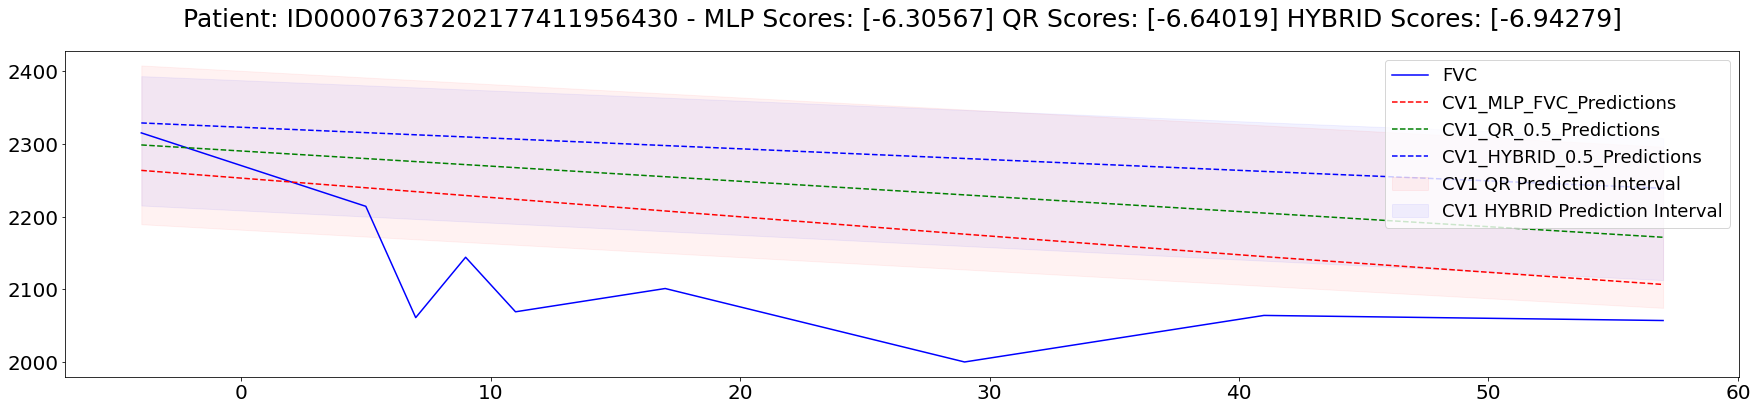

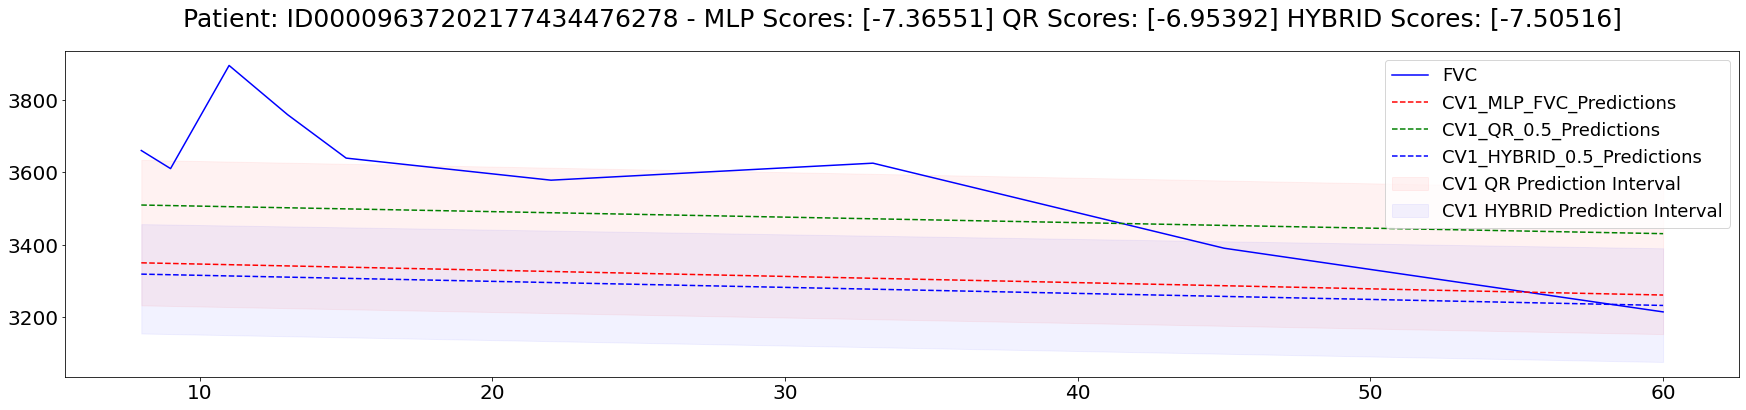

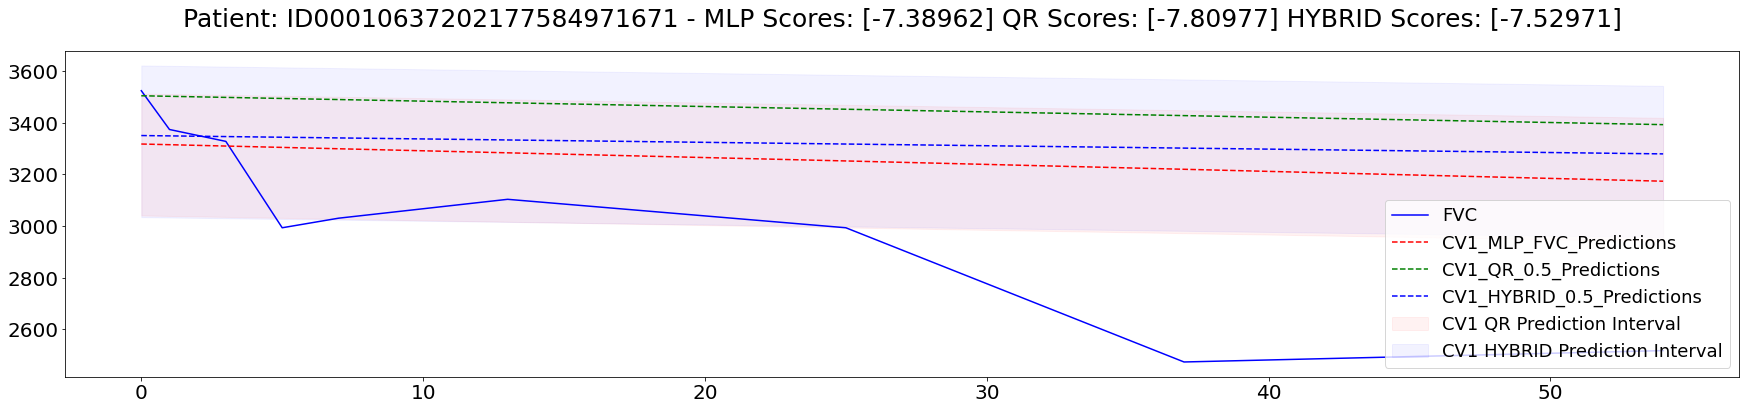

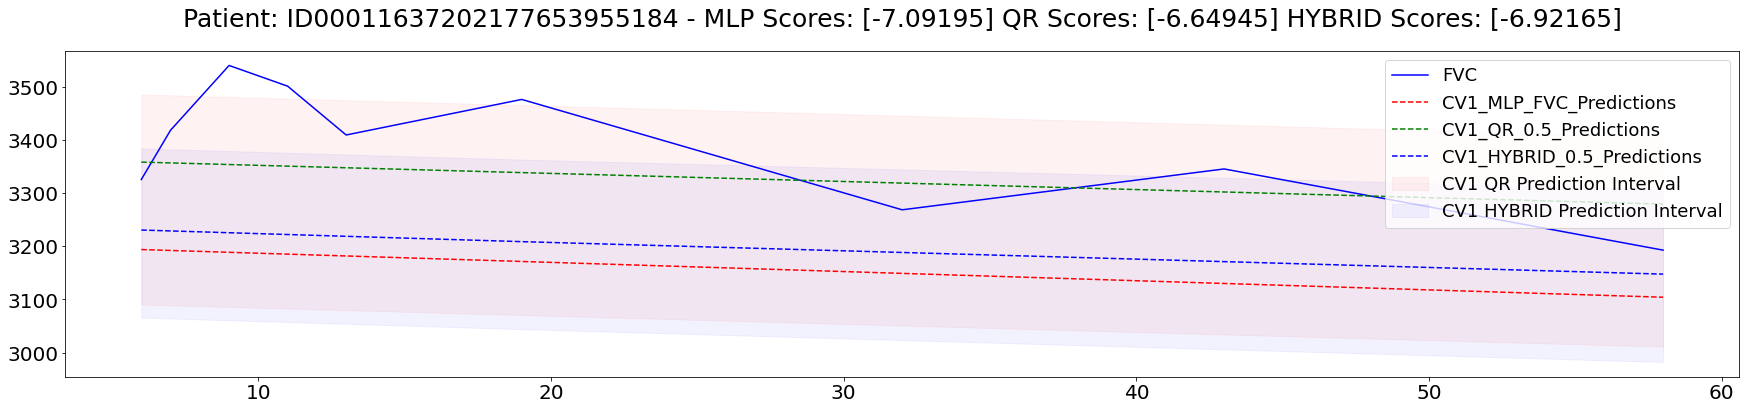

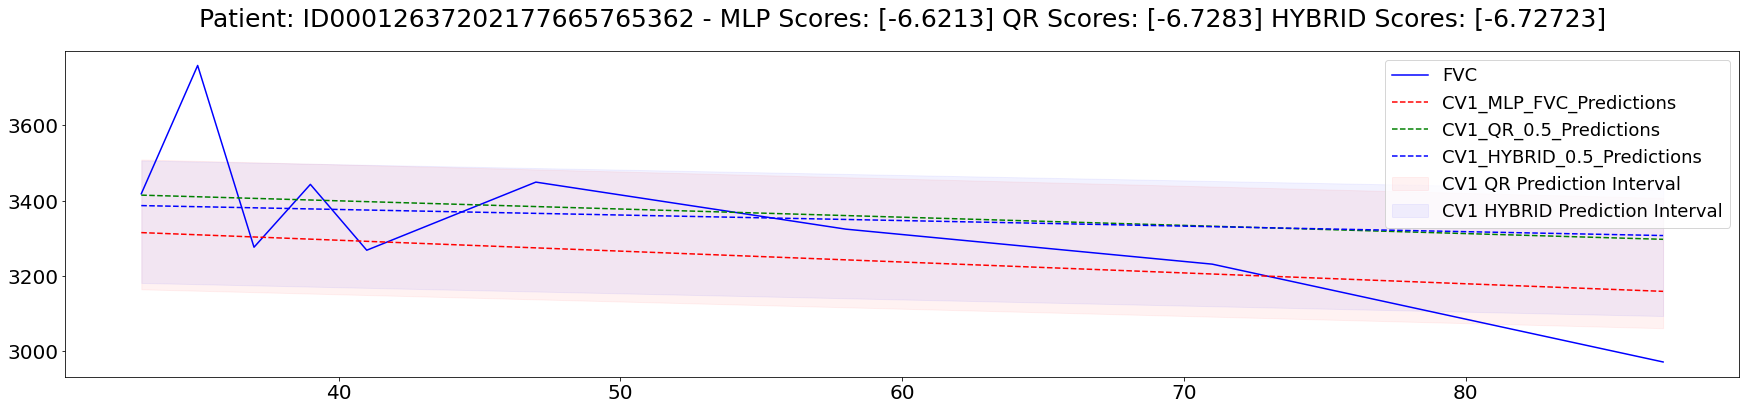

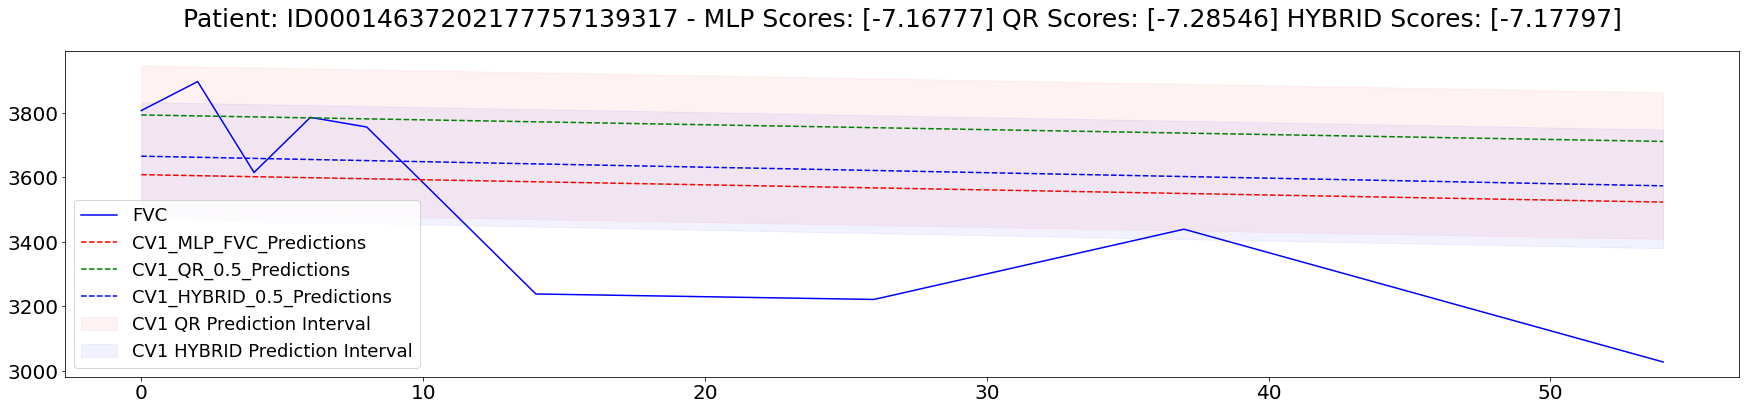

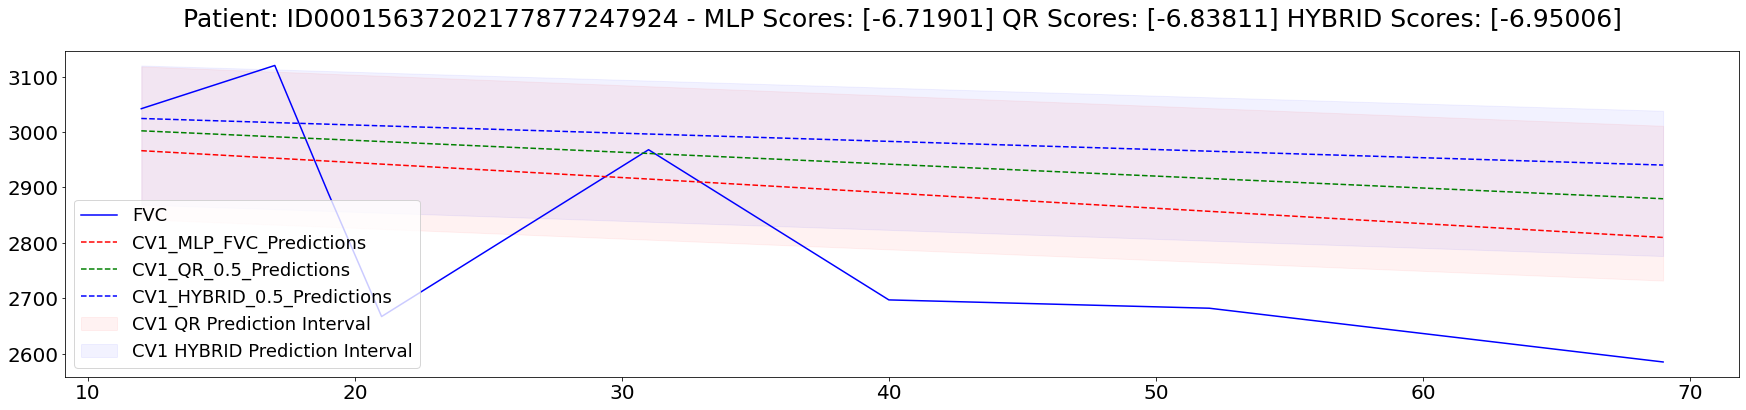

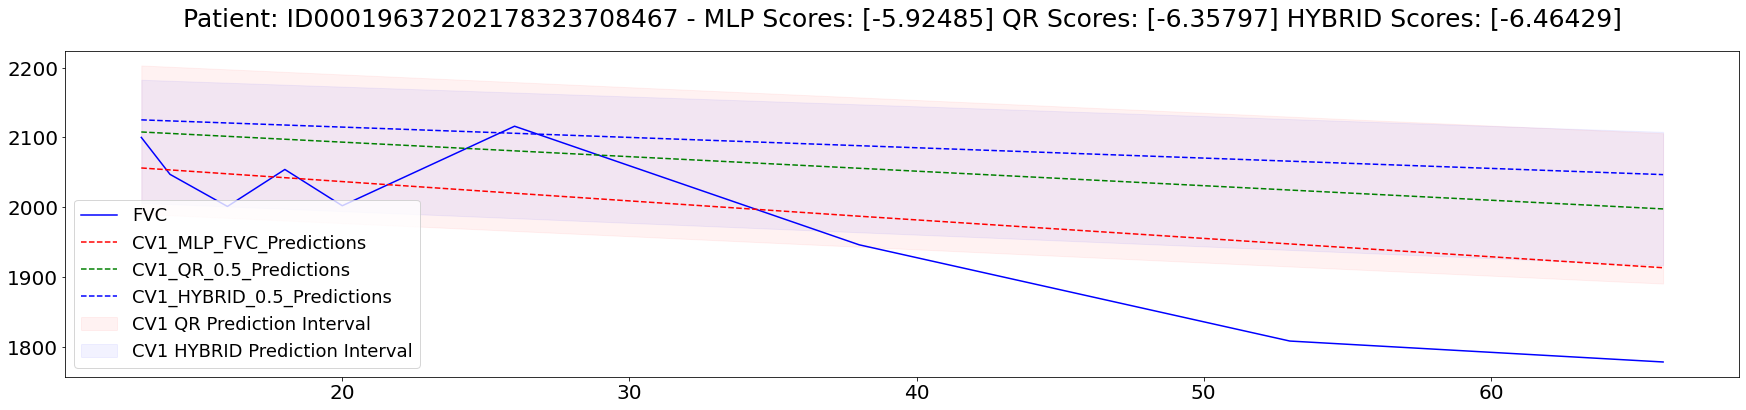

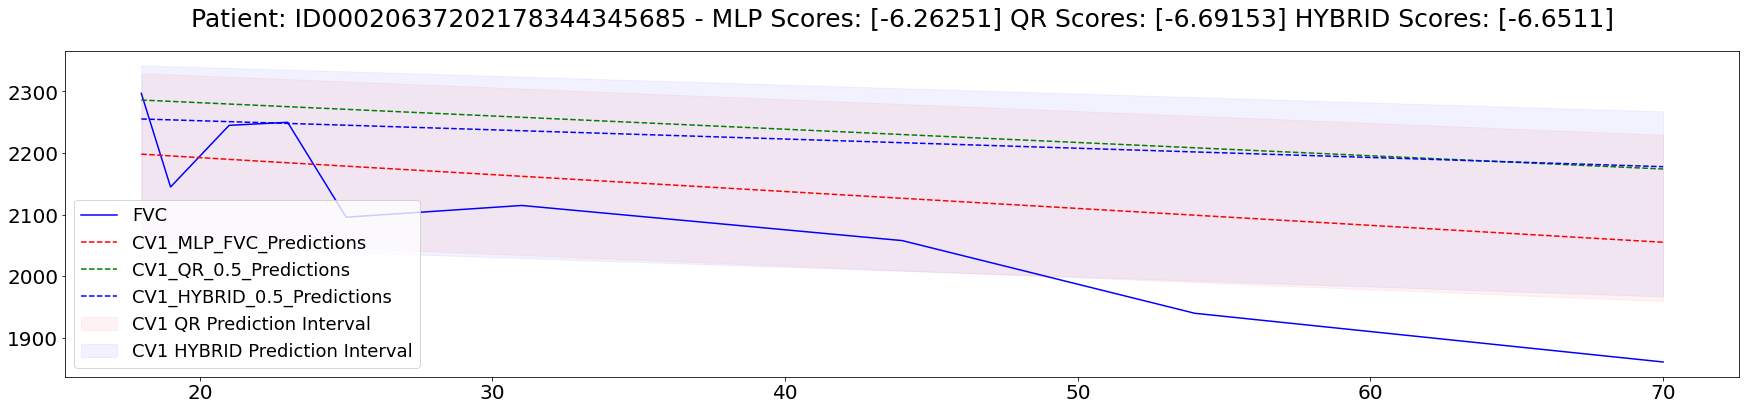

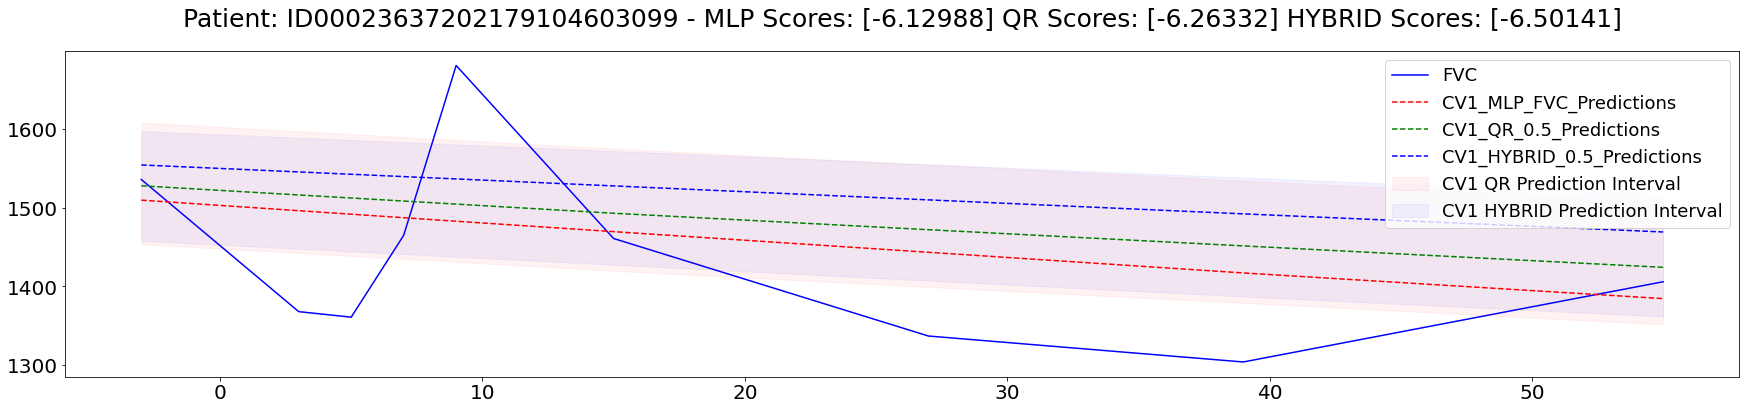

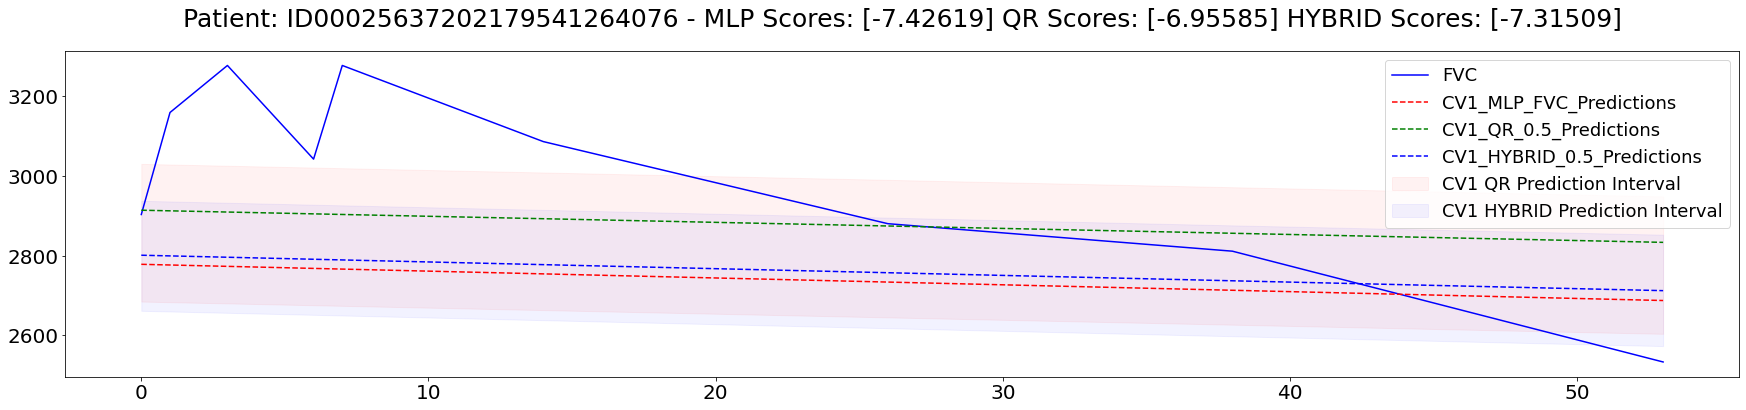

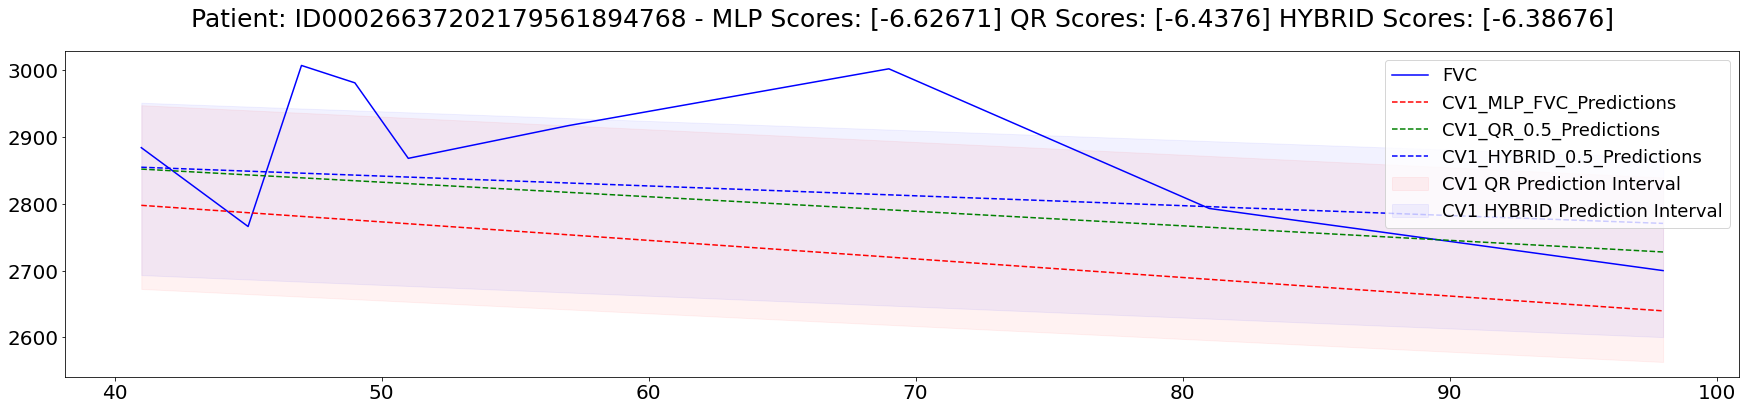

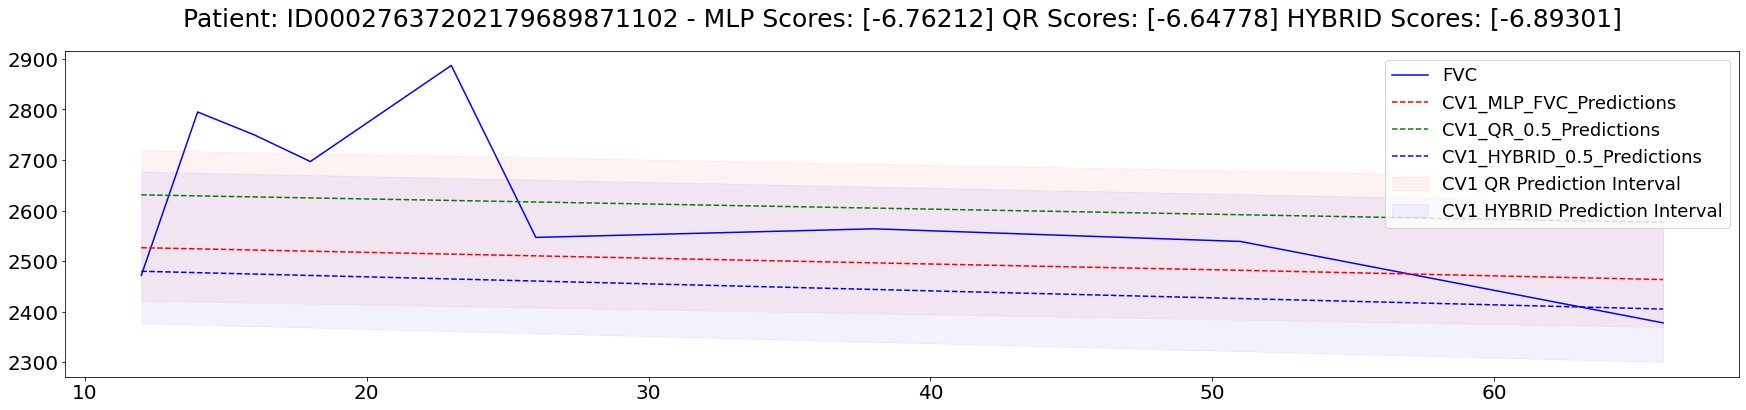

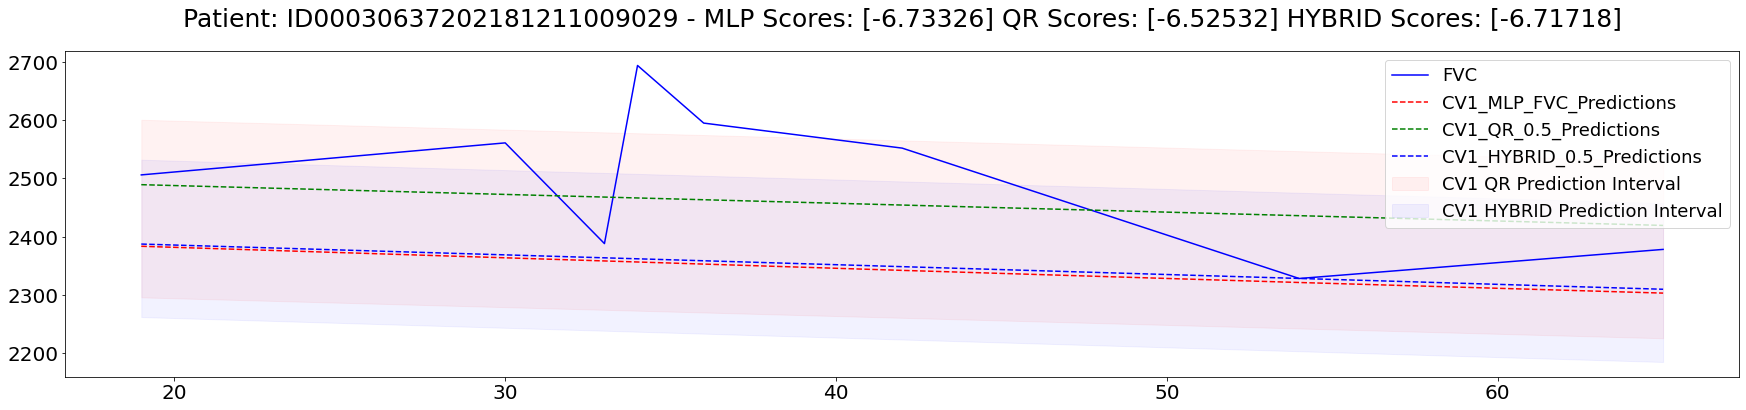

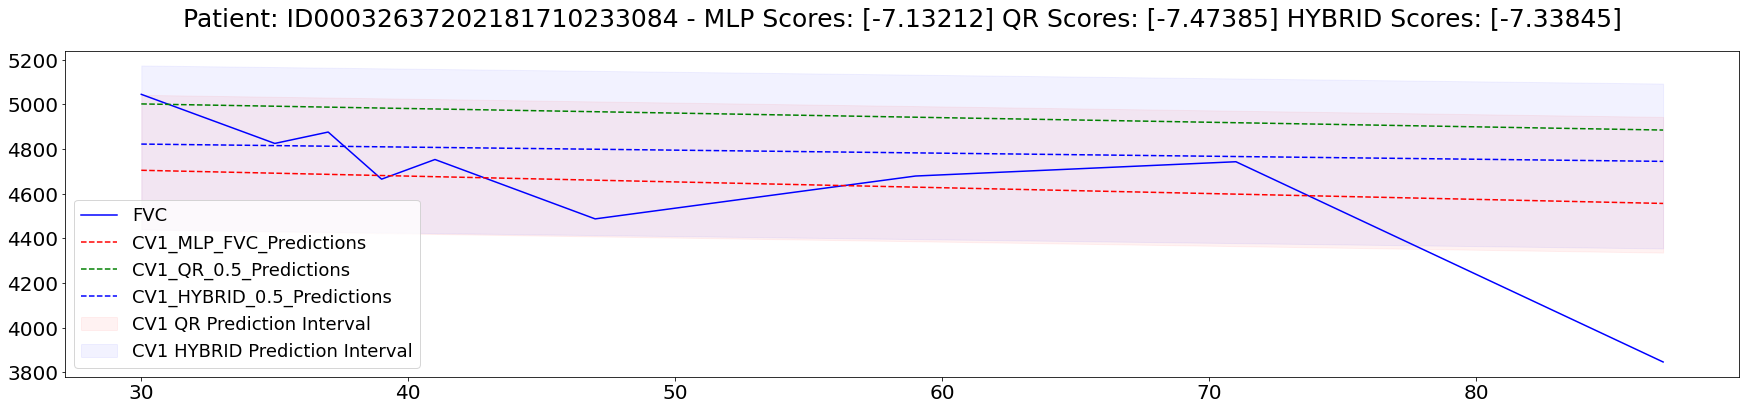

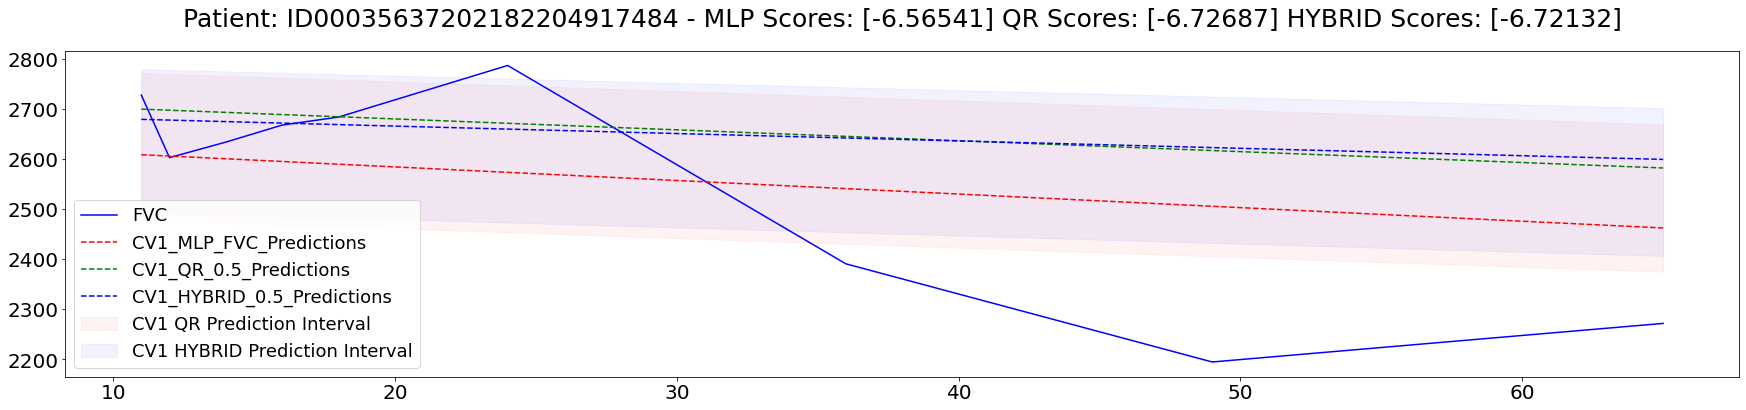

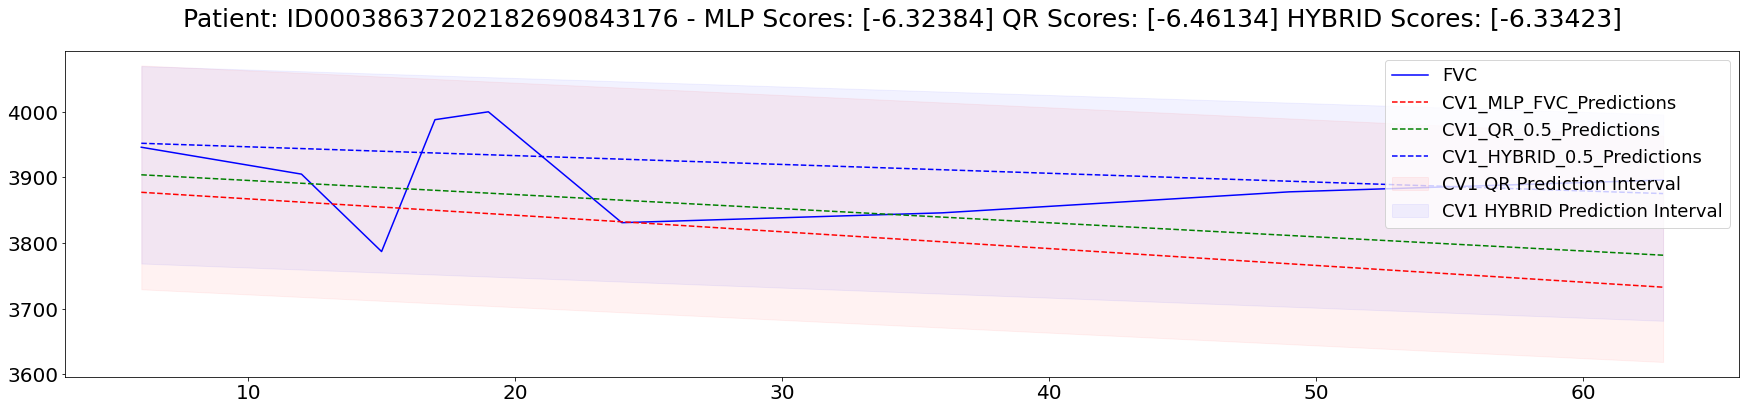

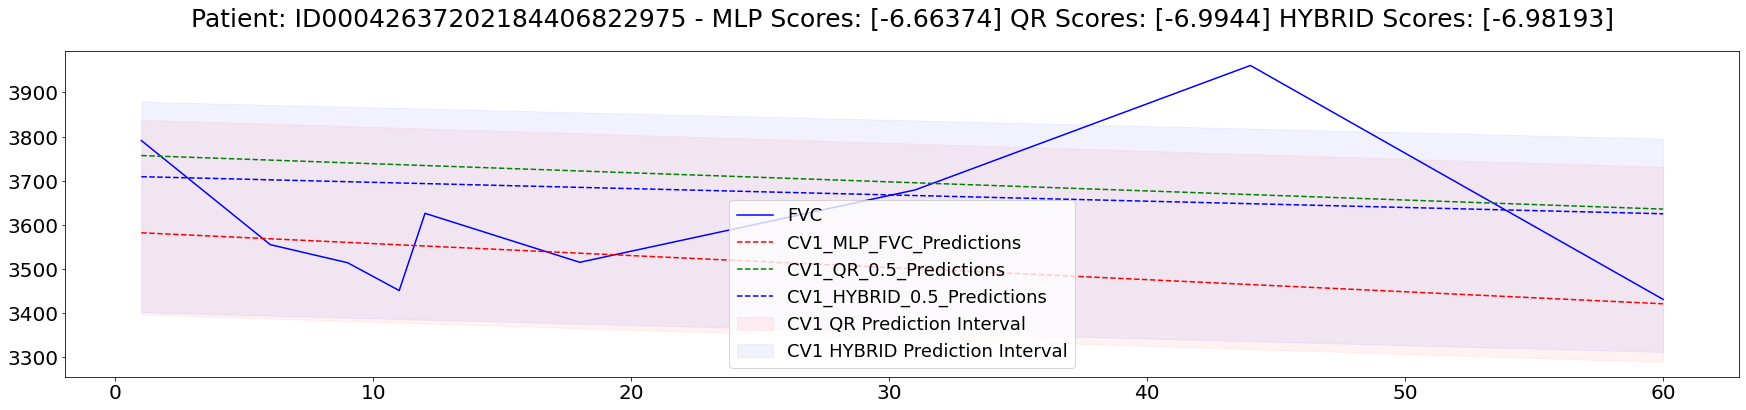

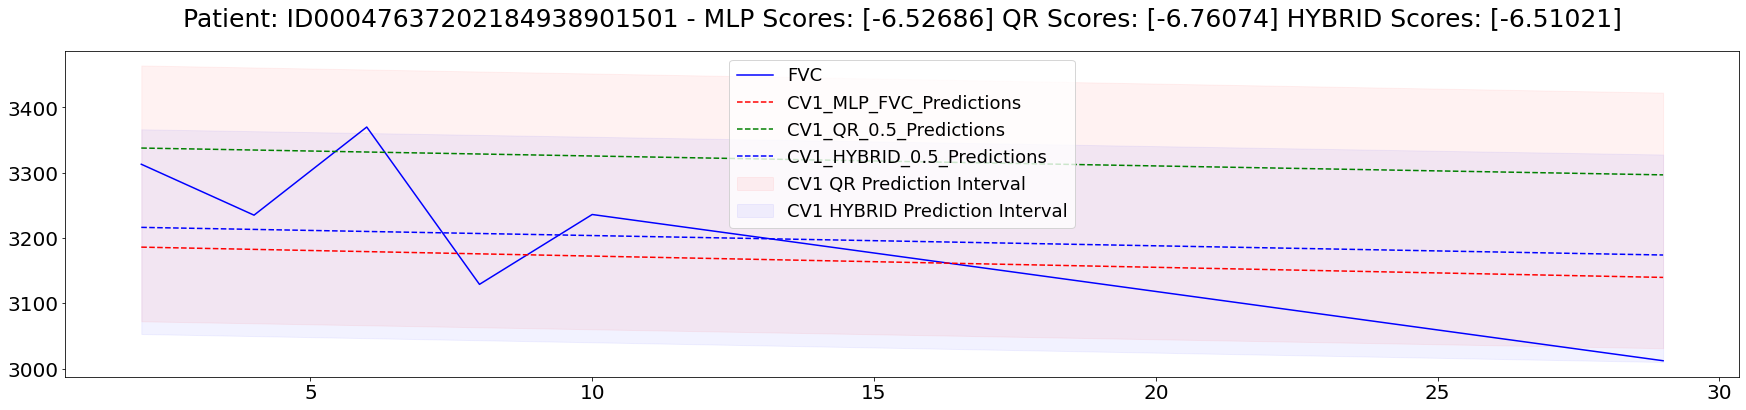

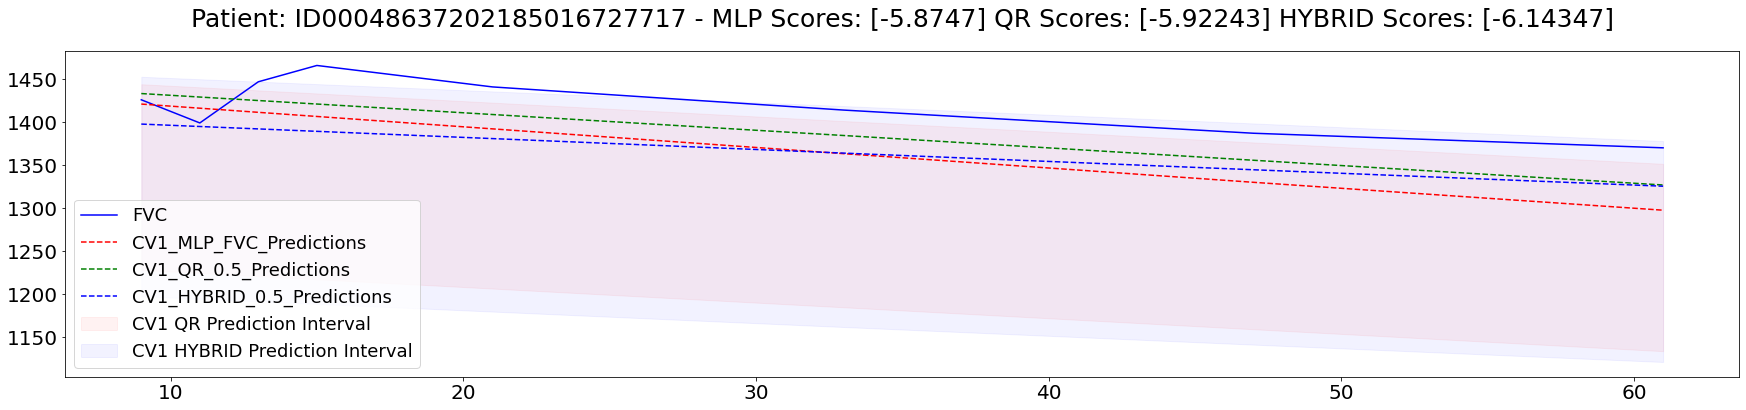

In [15]:
for patient, df in list(df_train.groupby('Patient'))[:20]:        
    qr_mlp.plot_predictions(df, patient)

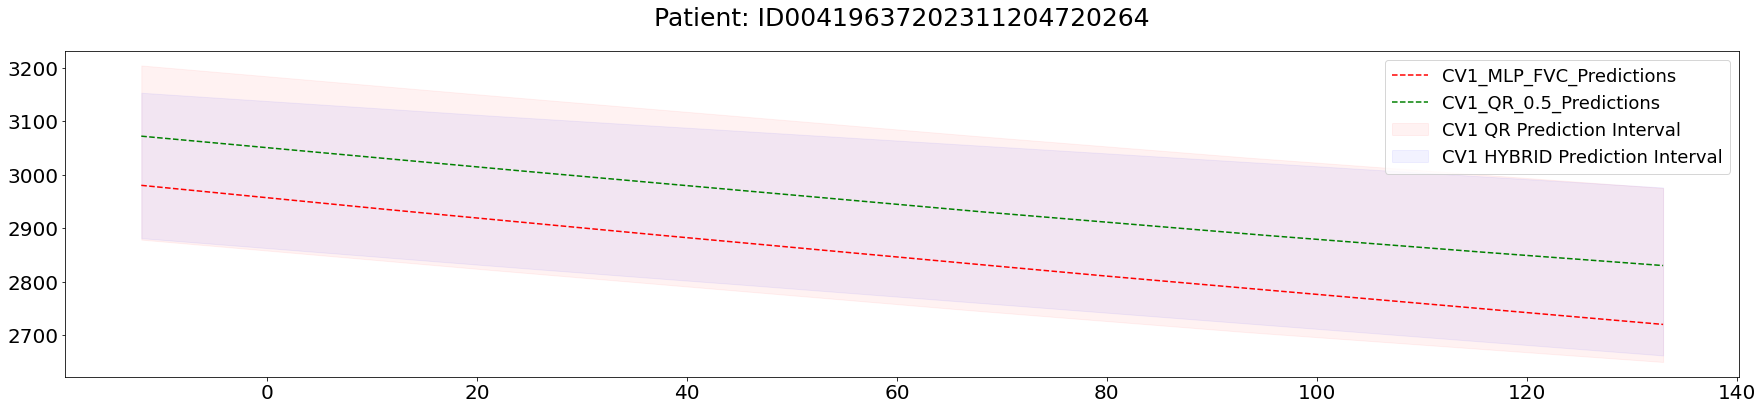

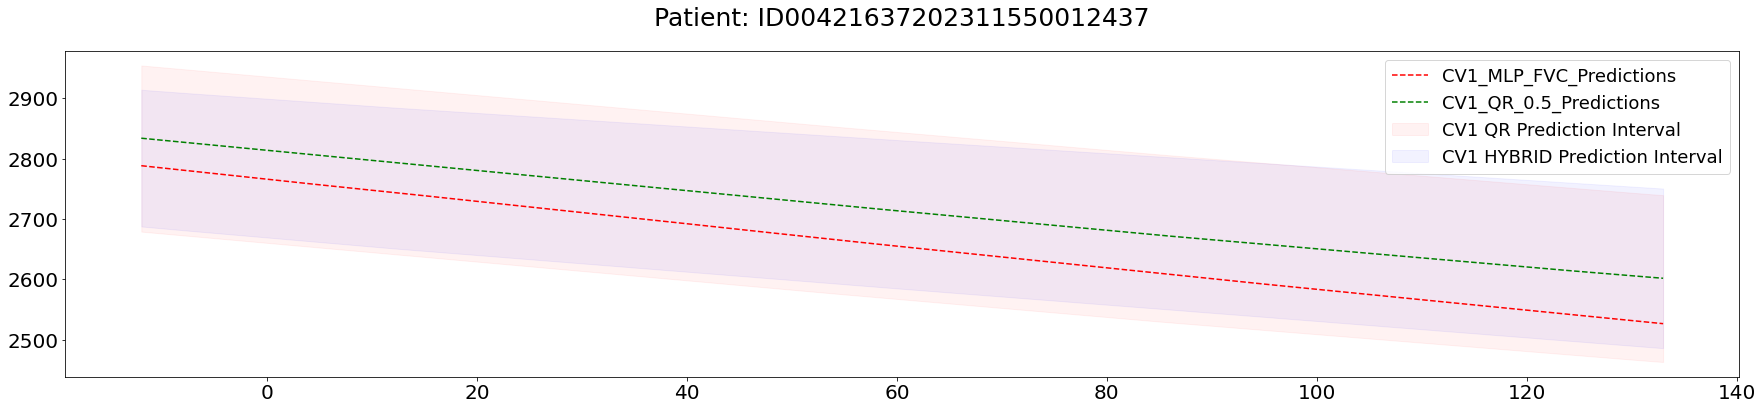

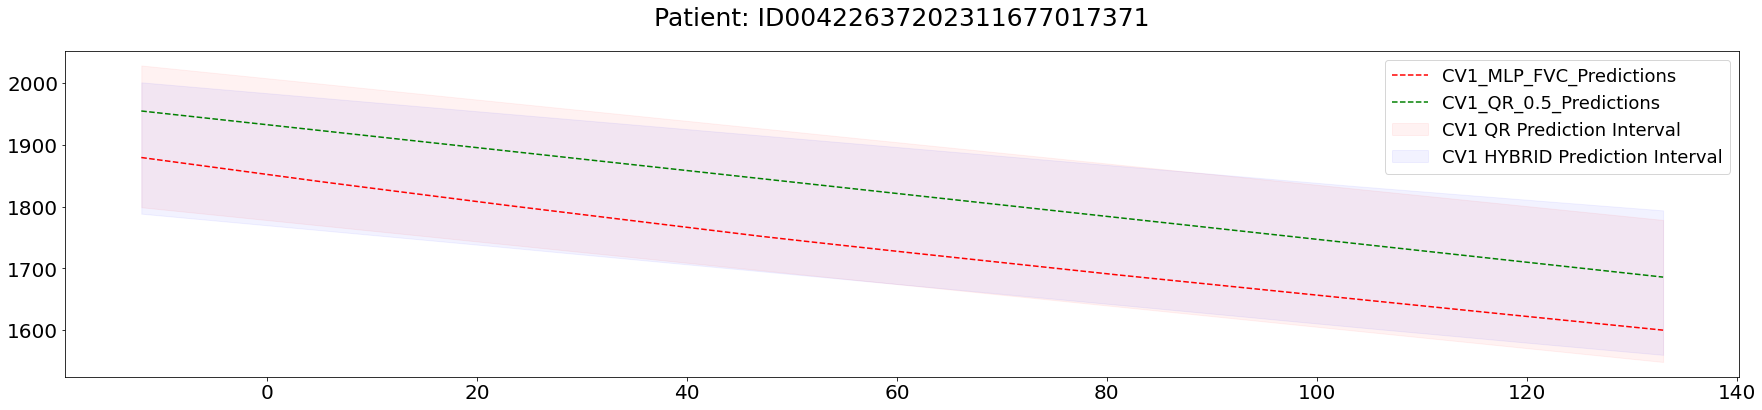

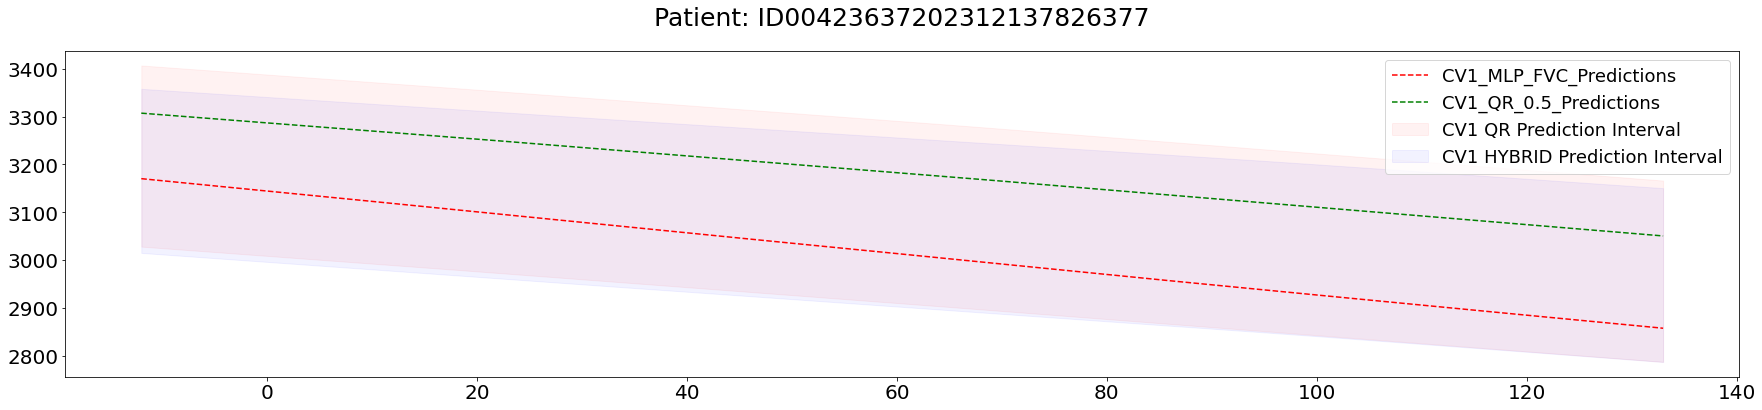

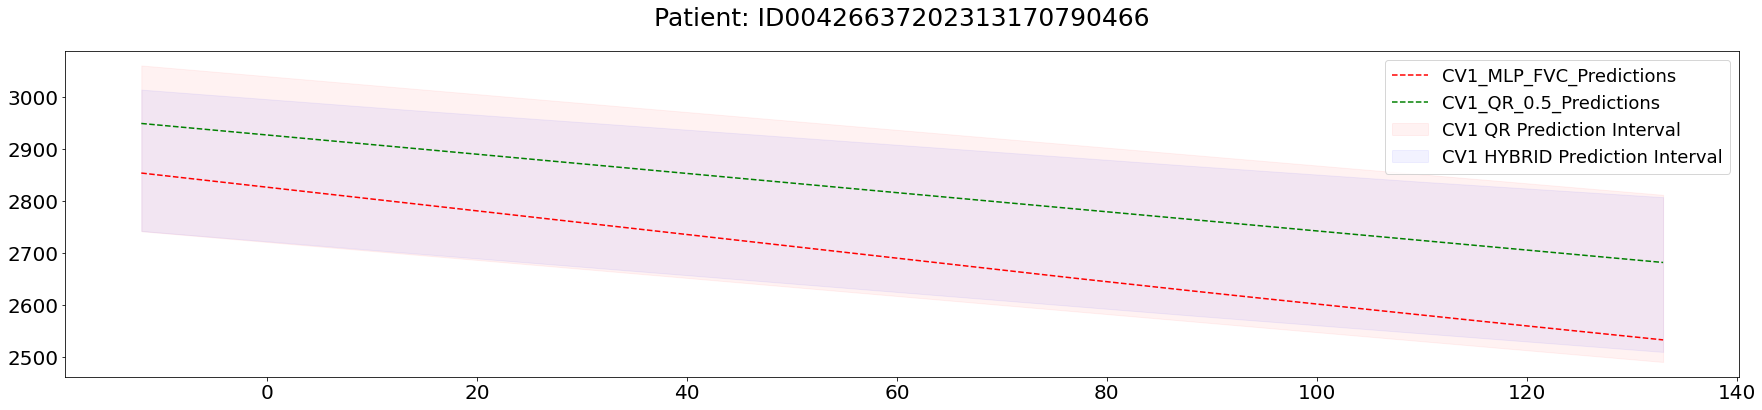

In [16]:
for patient, df in list(df_test.groupby('Patient'))[:5]:        
    qr_mlp.plot_predictions(df, patient)

## 3. Postprocessing

In [17]:
class SubmissionPipeline:
    
    def __init__(self, df_train, df_test):
        
        self.df_train = df_train
        self.df_test = df_test
        
    def laplace_log_likelihood_metric(self, y_true, y_pred, sigma):
        
        sigma_clipped = np.maximum(sigma, 70)
        delta_clipped = np.minimum(np.abs(y_true - y_pred), 1000)
        score = - np.sqrt(2) * delta_clipped / sigma_clipped - np.log(np.sqrt(2) * sigma_clipped)

        return np.mean(score)     
        
    def single_model(self, model):
        
        self.df_test['Patient_Week'] = self.df_test['Patient'].astype(str) + '_' + self.df_test['Weeks'].astype(str)
        
        prediction_cols = [col for col in self.df_train.columns if col.startswith(model)]
        if model.split('_')[1] == 'MLP':
            score = self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[prediction_cols[0]], self.df_train[prediction_cols[1]])
            print(f'Single Model {model} Score: {score:.6}')
            self.df_test['FVC'] = self.df_test[prediction_cols[0]]
            self.df_test['Confidence'] = self.df_test[prediction_cols[1]]
            
        elif model.split('_')[1] == 'QR' or model.split('_')[1] == 'LGB':
            score = self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[prediction_cols[1]], (self.df_train[prediction_cols[2]] - self.df_train[prediction_cols[0]]))
            print(f'Single Model {model} Score: {score:.6}')
            self.df_test['FVC'] = self.df_test[prediction_cols[1]]
            self.df_test['Confidence'] = self.df_test[prediction_cols[2]] - self.df_test[prediction_cols[0]]
            
        print(f'\n{self.df_test[["Patient_Week", "FVC", "Confidence"]].describe()}')            
        return self.df_test[['Patient_Week', 'FVC', 'Confidence']].copy(deep=True)
        
    def blend(self, by, model, cv):
        
        self.df_test['Patient_Week'] = self.df_test['Patient'].astype(str) + '_' + self.df_test['Weeks'].astype(str)
        
        if by == 'model':            
            if model == 'MLP':
                for df in [self.df_train, self.df_test]:
                    df[f'{model}_FVC'] = (df['CV1_MLP_FVC_Predictions'] * 0.34) + (df['CV2_MLP_FVC_Predictions'] * 0.33) + (df['CV3_MLP_FVC_Predictions'] * 0.33)
                    df[f'{model}_Confidence'] = (df['CV1_MLP_Confidence_Predictions'] * 0.34) + (df['CV2_MLP_Confidence_Predictions'] * 0.33) + (df['CV3_MLP_Confidence_Predictions'] * 0.33)
                    
                score = self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'{model}_FVC'], self.df_train[f'{model}_Confidence'])
                single_model_scores = [round(self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'CV{i}_MLP_FVC_Predictions'], self.df_train[f'CV{i}_MLP_Confidence_Predictions']), 6) for i in range(1, 4)]
                print(f'MLP Blend Score: {score:.6} - Single Model Scores: {single_model_scores}')
                
                self.df_test['FVC'] = self.df_test[f'{model}_FVC']
                self.df_test['Confidence'] = self.df_test[f'{model}_Confidence']
                
            elif model == 'QR':
                quantiles = [0.25, 0.50, 0.75]
                for df in [self.df_train, self.df_test]:
                    df[f'{model}_{quantiles[0]}_FVC'] = (df[f'CV1_QR_{quantiles[0]}_Predictions'] * 0.34) + (df[f'CV2_QR_{quantiles[0]}_Predictions'] * 0.33) + (df[f'CV3_QR_{quantiles[0]}_Predictions'] * 0.33)
                    df[f'{model}_{quantiles[1]}_FVC'] = (df[f'CV1_QR_{quantiles[1]}_Predictions'] * 0.34) + (df[f'CV2_QR_{quantiles[1]}_Predictions'] * 0.33) + (df[f'CV3_QR_{quantiles[1]}_Predictions'] * 0.33)
                    df[f'{model}_{quantiles[2]}_FVC'] = (df[f'CV1_QR_{quantiles[2]}_Predictions'] * 0.34) + (df[f'CV2_QR_{quantiles[2]}_Predictions'] * 0.33) + (df[f'CV3_QR_{quantiles[2]}_Predictions'] * 0.33)
                    
                score = self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'{model}_{quantiles[1]}_FVC'], (self.df_train[f'{model}_{quantiles[2]}_FVC'] - self.df_train[f'{model}_{quantiles[0]}_FVC']))
                single_model_scores = [round(self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'CV{i}_QR_{quantiles[1]}_Predictions'], (self.df_train[f'CV{i}_QR_{quantiles[2]}_Predictions'] - self.df_train[f'CV{i}_QR_{quantiles[0]}_Predictions'])), 6) for i in range(1, 4)]
                print(f'QR Blend Score: {score:.6} - Single Model Scores: {single_model_scores}')
                
                self.df_test['FVC'] = self.df_test[f'{model}_{quantiles[1]}_FVC']
                self.df_test['Confidence'] = self.df_test[f'{model}_{quantiles[2]}_FVC'] - self.df_test[f'{model}_{quantiles[0]}_FVC']

        elif by == 'cv':
            quantiles = [0.25, 0.50, 0.75]
            for df in [self.df_train, self.df_test]:
                df[f'CV{cv}_FVC'] = (df[f'CV{cv}_MLP_FVC_Predictions'] * 0.5) + (df[f'CV{cv}_QR_{quantiles[1]}_Predictions'] * 0.5)
                df[f'CV{cv}_Confidence'] = (df[f'CV{cv}_MLP_Confidence_Predictions'] * 0.5) + ((df[f'CV{cv}_QR_{quantiles[2]}_Predictions'] - df[f'CV{cv}_QR_{quantiles[0]}_Predictions']) * 0.5)
                
            score = self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'CV{cv}_FVC'], self.df_train[f'CV{cv}_Confidence'])
            single_model_scores = [round(self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'CV{cv}_MLP_FVC_Predictions'], self.df_train[f'CV{cv}_MLP_Confidence_Predictions']), 6), round(self.laplace_log_likelihood_metric(self.df_train['FVC'], self.df_train[f'CV{cv}_QR_{quantiles[1]}_Predictions'], (self.df_train[f'CV{cv}_QR_{quantiles[2]}_Predictions'] - self.df_train[f'CV{cv}_QR_{quantiles[0]}_Predictions'])), 6)]
            print(f'CV{cv} Blend Score: {score:.6} - Single Model Scores: {single_model_scores}')
            
            self.df_test['FVC'] = self.df_test[f'CV{cv}_FVC']
            self.df_test['Confidence'] = self.df_test[f'CV{cv}_Confidence']
            
        print(f'\n{self.df_test[["Patient_Week", "FVC", "Confidence"]].describe()}') 
        return self.df_test[['Patient_Week', 'FVC', 'Confidence']].copy(deep=True)


In [18]:
sub = SubmissionPipeline(df_train, df_test)
df_submission = sub.blend(by='cv', model=None, cv=1)
df_submission.to_csv('submission.csv', index=False)

CV1 Blend Score: -6.70597 - Single Model Scores: [-6.748425, -6.768143]

               FVC  Confidence
count   730.000000  730.000000
mean   2641.468976  276.560564
std     462.319403   40.468961
min    1643.279694  205.565536
25%    2615.482681  246.782458
50%    2780.381714  288.202410
75%    2956.457901  304.170918
max    3238.768494  337.590775
